# Model Time Series for COVID

## import

In [45]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error


## Definitions

In [46]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_SINGLE_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_single_step_pos_fr"
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr"

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

##  Helper functions

In [47]:
# FOR MODEL
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1)]
    else:
        return None

# EXTRACT DATA
def extract_data_world(df_world_melt, df_death_melt, str_filter, str_value):
    '''
    Extract data cases & death for one country by date from df_world_melt
    
    '''

    df_cases = df_world_melt[df_world_melt[str_filter] == str_value]
    

    s_cases = df_cases.groupby("date")["nb_cases"].sum()
    df_cases_out = pd.DataFrame(columns=["date", "nb_cases"])
    df_cases_out["nb_cases"] = s_cases.values
    df_cases_out["date"] = s_cases.index
    
    if df_death_melt is not None:
        df_death = df_death_melt[df_death_melt[str_filter] == str_value]
        s_death = df_death.groupby("date")["nb_death"].sum()
        df_death_out = pd.DataFrame(columns=["date", "nb_death"])
        df_death_out["nb_death"] = s_death.values
        df_death_out["date"] = s_death.index
        return df_cases_out, df_death_out 
    else:
        print("one output ...")
        return df_cases_out 

# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [48]:
# load dep
#df_dep_fr = pd.read_csv(PATH_GEO_DEP_FR)
##############################
# GOUV FR : UPDATE DATA 
#
# New source : "https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675"
# https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/#_
URL_CSV_GOUV_FR = \
    'https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675'

# patch 29/07/2020 : SSL error patch
req = requests.get(URL_CSV_GOUV_FR).content
df_gouv_fr_raw = pd.read_csv(io.StringIO(req.decode('utf-8')), sep=";")

# past treat data upper cases -> lower cases
if "t" not in df_gouv_fr_raw.columns:
    df_gouv_fr_raw["t"] =  df_gouv_fr_raw["T"]
if "p" not in df_gouv_fr_raw.columns:
    df_gouv_fr_raw["p"] =  df_gouv_fr_raw["P"]
# patch : clear data in double !!!
df_gouv_fr_raw = df_gouv_fr_raw[df_gouv_fr_raw["cl_age90"] != 0]

# creation of table data : 't':tested 'p':positive
# data =  f(line : date, dep / col: t) => f(line : date / col: dep = f(t)) 
pt_fr_test = pd.pivot_table(df_gouv_fr_raw, values=['t', 'p'], 
                            index=["jour"],
                    columns=["dep"], aggfunc=np.sum) 
pt_fr_test["date"] = pt_fr_test.index

# save data
df_pos_fr = pt_fr_test["p"].copy()
df_pos_fr.index = pt_fr_test["date"].index
df_pos_fr["date"] = df_pos_fr.index
df_pos_fr.to_csv(PATH_DF_POS_FR, index=False)

df_test_fr = pt_fr_test["t"].copy()
df_test_fr.index = pt_fr_test["date"].index
df_test_fr["date"] = df_test_fr.index
df_test_fr.to_csv(PATH_DF_TEST_FR, index=False)


In [49]:
df_pos_fr

dep,01,02,03,04,05,06,07,08,09,10,...,95,971,972,973,974,975,976,977,978,date
jour,,,,,,,,,,,,,,,,,,,,,
2020-05-13,9,14,0,1,0,19,4,6,1,3,...,25,0,4,0,1,0,9,0,0,2020-05-13
2020-05-14,9,14,2,2,7,24,4,2,0,0,...,33,0,4,0,1,0,9,0,0,2020-05-14
2020-05-15,5,11,2,1,0,20,5,5,1,5,...,19,0,0,0,1,0,12,0,0,2020-05-15
2020-05-16,0,7,2,0,0,2,0,1,0,0,...,3,0,1,0,1,0,0,0,0,2020-05-16
2020-05-17,0,2,1,0,0,2,0,0,0,0,...,9,0,0,0,3,0,0,0,0,2020-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-23,6,4,4,2,0,16,6,3,0,0,...,49,5,0,97,11,0,17,0,0,2020-07-23
2020-07-24,16,4,1,0,0,48,0,0,1,0,...,43,6,2,105,1,0,14,0,0,2020-07-24
2020-07-25,2,2,4,0,1,9,0,0,0,0,...,14,1,0,64,1,0,1,0,0,2020-07-25


In [50]:
def create_url_meteo_date(str_date):
    # str_date = 2020-05-10
    num_records_max = 10000
    return 'https://public.opendatasoft.com/api/records/1.0/search/' + \
        f'?dataset=donnees-synop-essentielles-omm&q=&rows={num_records_max}' + \
        f'&sort=date&refine.date={str_date}'

def get_data_meteo_by_date(str_date):
    '''
    get data meteo for 1 day on date str_date 
    
    example : get_data_meteo_by_date("2020-01-24")
    '''
    # download raw json object
    url = create_url_meteo_date(str_date)
    data = urllib.request.urlopen(url).read().decode()
    # parse json object
    return json.loads(data)

def get_data_meteo_by_list(list_date):
    '''
    Retrieve data meteo for a list of dates
    '''
    for I, date_curr in enumerate(list_date):
        
        data_curr = get_data_meteo_by_date(date_curr)
        
        if I:
            data_out["records"] = data_out["records"] + data_curr["records"]
        else:
            data_out = data_curr.copy()
            
    return data_out
    

def create_url_meteo(num_records, num_start=0):
    # https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm  
    return 'https://public.opendatasoft.com/api/records/1.0/search/' + \
        f'?dataset=donnees-synop-essentielles-omm&q=&rows={num_records}' + \
        f'&sort=date&start={num_start}'

def get_data_meteo(num_records, num_start=0):
    # num_records max = 10000
    # download raw json object
    url = create_url_meteo(num_records, num_start)
    data = urllib.request.urlopen(url).read().decode()
    # parse json object
    return json.loads(data)
def days_between(str_date_0, str_date_1):
    '''
    calculate days between 2 string dates
    '''
    date_format = "%Y-%m-%d"
    
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    '''date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start'''
    return delta

# function about data meteo from json 
def get_data_meteo_date_list(data): 
    return np.unique([data["records"][I]["fields"]["date"][0:10] \
                for I in range(len(data["records"]))]).tolist()
def get_data_meteo_date_min(data):
    list_date = get_data_meteo_date_list(data)
    return min(list_date)[0:10]
def get_data_meteo_date_max(data):
    list_date = get_data_meteo_date_list(data)
    return max(list_date)[0:10]

#days_between(df_pos_fr.date.min(), )

In [51]:
# first time : 
if os.path.isfile(PATH_JSON_METEO_FR):
    f_reload_from_start = False
    f_load_missing = False
    # load
    with open(PATH_JSON_METEO_FR) as f:
        data_meteo = json.load(f)
    # check start date
    date_meteo_start = get_data_meteo_date_min(data_meteo)
    delta_days = days_between(df_pos_fr.date.min(), date_meteo_start)
    if delta_days.days > 0:
        print(f"Must reload from start, {delta_days.days} days missing")
        f_reload_from_start = True
    # check last date
    date_meteo_end = get_data_meteo_date_max(data_meteo)
    delta_days = days_between(date_meteo_end, df_pos_fr.date.max())
    if delta_days.days > 0:
        print(f"Must load more last days, {delta_days.days} days missing")
        f_load_missing = True
    
    # determine list of days to download
    list_dates = None
    if f_reload_from_start:
        # all dates between [FORCED]
        list_dates = df_pos_fr["date"].tolist()
    elif f_load_missing:
        # from date
        list_dates = df_pos_fr["date"].tolist()
        # remove days already downloaded:
        list_remove = get_data_meteo_date_list(data_meteo)
        #get_data_meteo_date_list(data_meteo)
        for item_curr in  list_remove:
            try:
                list_dates.remove(item_curr)
            except:
                print(f'{item_curr} not found in dates list')
    else:
        # download NOT needed
        list_dates = None
else:
    # all dates between [FORCED]
    f_reload_from_start = True
    f_load_missing = True
    list_dates = df_pos_fr["date"].tolist()
# if download needed
if list_dates is not None:
    data_meteo_new = get_data_meteo_by_list(list_dates)
    print(f'{len(data_meteo_new["records"])} records downloaded')
    
    if f_reload_from_start:
        # reload all
        data_meteo = data_meteo_new
    else:
        # add data
        data_meteo["records"] = data_meteo["records"] + \
            data_meteo_new["records"]      
    # save
    with open(PATH_JSON_METEO_FR, 'w') as outfile:
        json.dump(data_meteo, outfile)
else:
    print("Data meteo OK")


Data meteo OK


In [52]:
def get_rec_by_date(data_meteo, date_str):
    '''
    get one date data 
    '''
    
    # date_str = '2020-05-14'
    list_rec = []
    for rec_curr in data_meteo["records"]:
        if rec_curr['fields']["date"][0:10] == date_str:
            list_rec.append(rec_curr)
    data_out = data_meteo.copy()
    data_out["records"] = list_rec
    return data_out

def select_rec_by_station(data_meteo):
    '''
    Select list of list of data by station
    '''
    list_station = [data_meteo["records"][I]['fields']['numer_sta'] \
                    for I in range(len(data_meteo["records"]))]
    list_station = np.unique(list_station).tolist()
    
    list_rec = []
    for sta_curr in list_station:
        list_rec_curr = []
        for rec_curr in data_meteo["records"]:
            if rec_curr['fields']['numer_sta'] == sta_curr:
                list_rec_curr.append(rec_curr)
        list_rec.append(list_rec_curr)
            
    return list_rec


def get_field_in_list(list_rec, field_name):
    '''
    get a field from a list of list of data 
    '''
    list_field = []
    for I in range(len(list_rec)):
        list_field_curr = []
        for J in range(len(list_rec[I])):
            try:
                list_field_curr.append(list_rec[I][J]["fields"][field_name])
            except:
                continue
        if list_field_curr != []:
            list_field.append(list_field_curr)
    return list_field

def calculate_mean_field(list_field, fun):
    """
    calculate mean with fun on list of data
    """
    list_by_sta = []
    for list_curr in list_field:
        list_by_sta.append(fun(list_curr))

    return np.mean(list_by_sta)

def calc_list_mean_field(data_meteo, fieldname, fun):
    list_date = get_data_meteo_date_list(data_meteo)
    list_mean = []
    for date_curr in list_date:
        data_out = get_rec_by_date(data_meteo, date_curr)
        list_by_sta = select_rec_by_station(data_out)
        list_field = get_field_in_list(list_by_sta, fieldname)
        list_mean.append(calculate_mean_field(list_field, fun))
    return list_mean

In [53]:
# create features for model

# add meteo data

list_t_min = calc_list_mean_field(data_meteo, "t", min)
list_t_max = calc_list_mean_field(data_meteo, "t", max)
list_u_min = calc_list_mean_field(data_meteo, "u", min)
list_u_max = calc_list_mean_field(data_meteo, "u", max)

dict_meteo = dict()
dict_meteo["date"] = get_data_meteo_date_list(data_meteo)
dict_meteo["t_min"] = list_t_min
dict_meteo["t_max"] = list_t_max
dict_meteo["u_min"] = list_u_min
dict_meteo["u_max"] = list_u_max

df_feat_fr = pd.DataFrame(data=dict_meteo)
df_feat_fr.columns = ["date", "T_min", "T_max", "H_min", "H_max"]
df_feat_fr.sort_values(by="date", inplace=True)
df_feat_fr.index = df_feat_fr["date"]

# add positive cases
df_pos_fr["pos"] = 0
list_dep = []
for col_curr in df_pos_fr.columns:
    if re.search("^\d", col_curr):
        list_dep.append(col_curr)

for dep_curr in list_dep:
    df_pos_fr["pos"] += df_pos_fr[dep_curr]

df_feat_fr["pos"] = df_pos_fr["pos"].copy()

# add tested cases
df_test_fr["test"] = 0
list_dep = []
for col_curr in df_test_fr.columns:
    if re.search("^\d", col_curr):
        list_dep.append(col_curr)

for dep_curr in list_dep:
    df_test_fr["test"] += df_test_fr[dep_curr]
    
df_feat_fr["test"] = df_test_fr["test"].copy()

# add num days
df_feat_fr['day_num'] = \
    df_feat_fr["date"].astype(np.datetime64).dt.strftime("%w")

# add nb_cases
arr_nb_cases = df_feat_fr["pos"].cumsum().values
df_feat_fr["nb_cases"] = NB_POS_DATE_MIN_DF_FEAT + arr_nb_cases

df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,test,day_num,nb_cases
date,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,881,38924,3,141108
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,979,41696,4,142087
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,47159,5,143117
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,287,16180,6,143404
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,138,6276,0,143542
...,...,...,...,...,...,...,...,...,...
2020-07-23,2020-07-23,289.468333,299.050000,47.508475,82.067797,1114,78659,4,180976
2020-07-24,2020-07-24,290.650000,298.187288,49.948276,80.896552,1249,85482,5,182225
2020-07-25,2020-07-25,290.195000,298.233333,51.086207,83.379310,601,38372,6,182826


### save

In [54]:
# save 
clean_file(PATH_DF_FEAT_FR)
df_feat_fr.to_csv(PATH_DF_FEAT_FR, index=False)

File ./df_feat_fr_20200731_18_35_57.csv moved!


### Train/Test split

In [20]:
# keep 25 Validation samples:
TRAIN_SPLIT = df_feat_fr.shape[0] - 25
#TRAIN_SPLIT = 45
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 51


## Exploration

In [15]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,test,day_num
date,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,881,38923,3
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,976,41647,4
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,47158,5
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,287,16180,6
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,138,6276,0
...,...,...,...,...,...,...,...,...
2020-07-22,2020-07-22,289.838333,299.035000,47.559322,79.949153,1135,79601,3
2020-07-23,2020-07-23,289.468333,299.050000,47.508475,82.067797,1093,78126,4
2020-07-24,2020-07-24,290.650000,298.187288,49.948276,80.896552,1195,84227,5


In [225]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,test,day_num,nb_cases,train
date,,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,881,38923,3,141108,True
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,979,41695,4,142087,True
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,47156,5,143117,True
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,16186,6,143408,True
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,6278,0,143547,True
...,...,...,...,...,...,...,...,...,...,...
2020-07-29,2020-07-29,289.555085,299.031356,49.982759,85.379310,1420,95597,3,187263,False
2020-07-30,2020-07-30,290.362069,302.794828,44.333333,80.912281,1496,92410,4,188759,False
2020-07-31,2020-07-31,292.482203,303.165254,46.086207,78.103448,1539,95617,5,190298,False


Distribution of TRAIN / VALIDATION dataset :

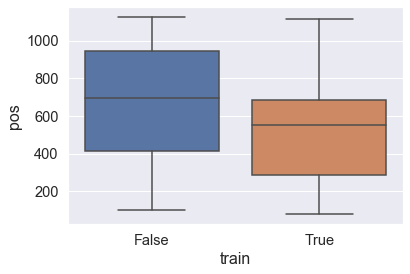

In [14]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### Impact of day 

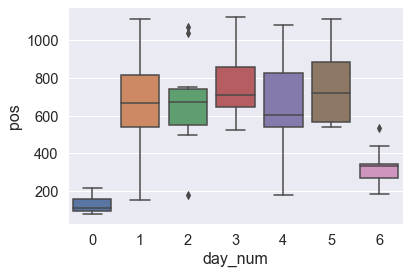

In [15]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [16]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

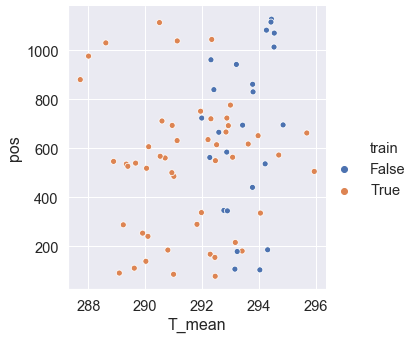

In [17]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

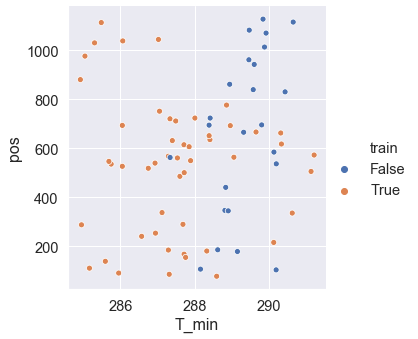

In [18]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

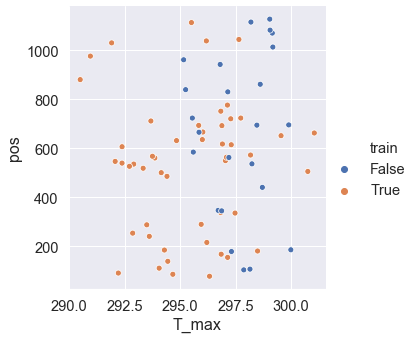

In [19]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

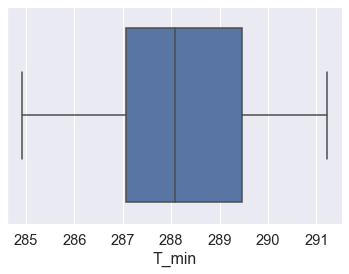

In [20]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [21]:
df_feat_fr["T_min"].mean()

288.1095243132948

In [22]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

True     37
False    37
Name: T_min, dtype: int64

In [23]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

True     37
False    37
Name: T_min, dtype: int64

In [24]:
df_feat_fr["T_min"].median()

288.0812994350283

In [25]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

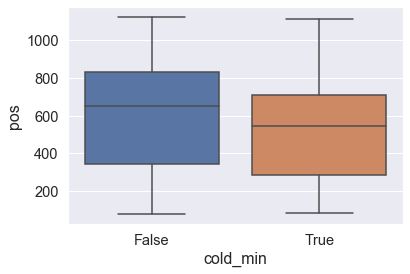

In [26]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then less positive cases! (strange behaviour... opposite of flu ?)

Impact of T mean : 

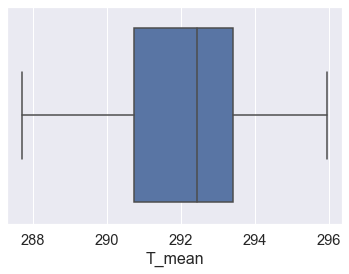

In [27]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [28]:
df_feat_fr["T_mean"].median()

292.4304025423729

In [29]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

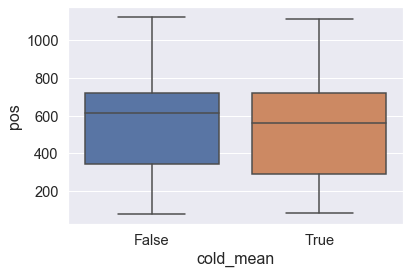

In [30]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

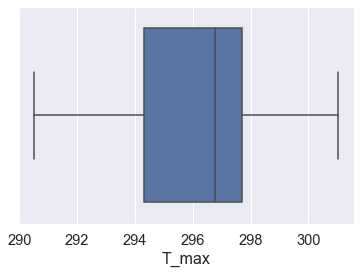

In [31]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [32]:
df_feat_fr["T_max"].median()

296.7583333333333

In [33]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

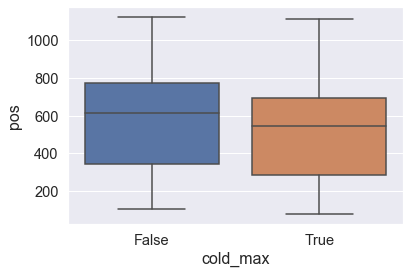

In [34]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> far less significant in comparison with day_num

### Impact of Humidity

In [35]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

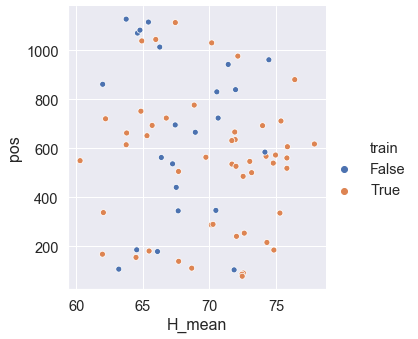

In [36]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

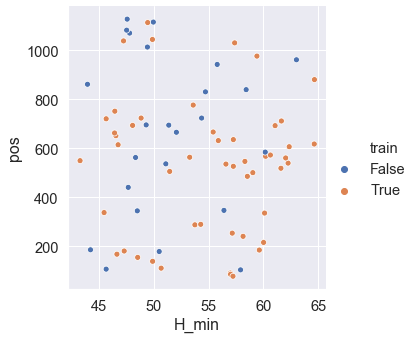

In [37]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

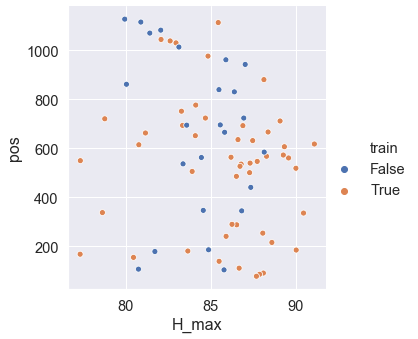

In [38]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

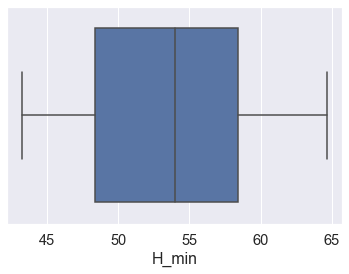

In [39]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [40]:
df_feat_fr["H_min"].median()

54.008620689655174

In [41]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

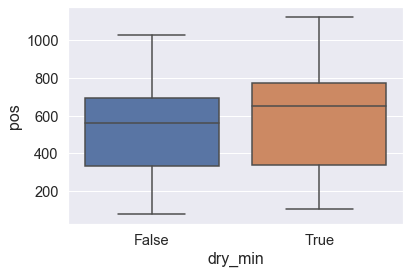

In [42]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> maybe dry more positive cases ?

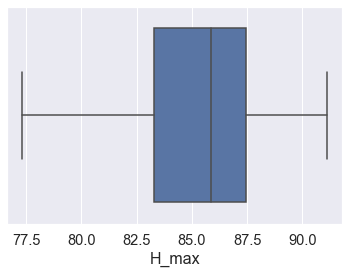

In [43]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [44]:
df_feat_fr["H_max"].median()

85.86143324412727

In [45]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

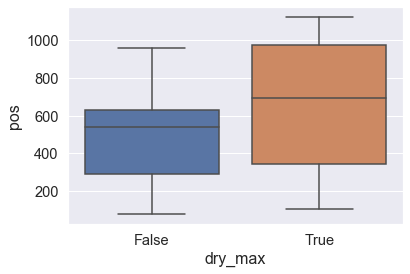

In [46]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> real impact of Hmax?

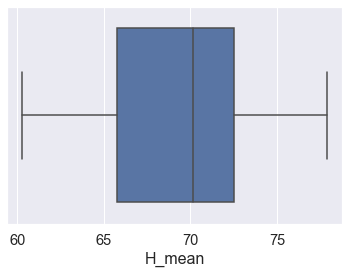

In [47]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [48]:
df_feat_fr["H_mean"].median()

70.15371127995323

In [49]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

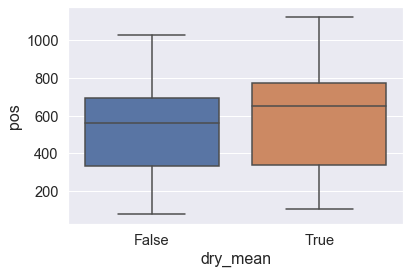

In [50]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same maybe impact of humidity H_max => dryer then more positive cases ?

### Seasonality impact

In [51]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

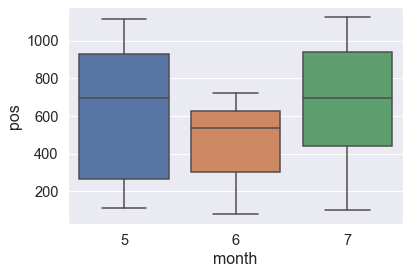

In [52]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

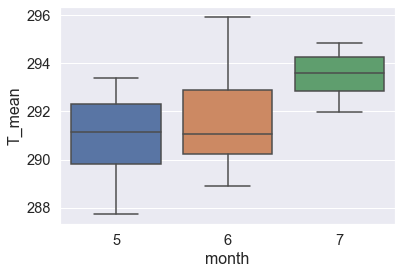

In [53]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

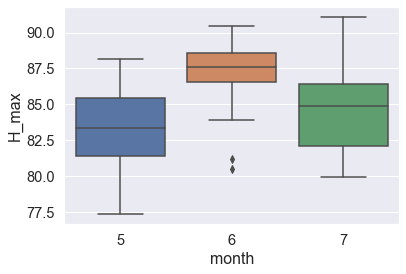

In [54]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [55]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

,pos
month,
5,11643
6,14075
7,16618


### Nb Tested

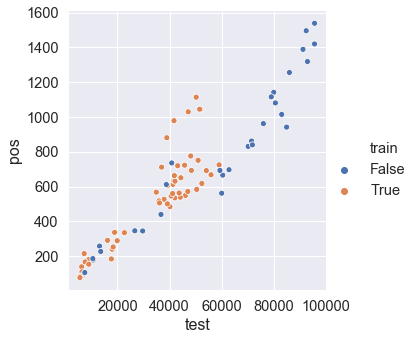

In [226]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [234]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [235]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [190]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [17]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num'])
features

,T_min,T_max,H_min,H_max,pos,test,day_num
date,,,,,,,
2020-05-13,284.926667,290.505000,64.661017,88.135593,881,38923,3
2020-05-14,285.050000,290.963333,59.406780,84.847458,976,41647,4
2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,47158,5
2020-05-16,284.956667,293.500000,53.741379,86.534483,287,16180,6
2020-05-17,285.598333,294.446667,49.879310,85.500000,138,6276,0
...,...,...,...,...,...,...,...
2020-07-22,289.838333,299.035000,47.559322,79.949153,1135,79601,3
2020-07-23,289.468333,299.050000,47.508475,82.067797,1093,78126,4
2020-07-24,290.650000,298.187288,49.948276,80.896552,1195,84227,5


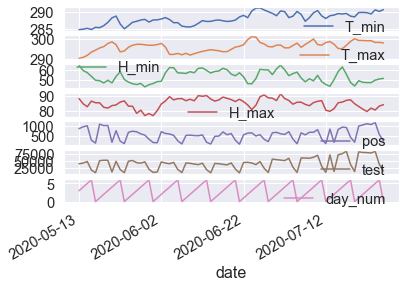

In [18]:
features.plot(subplots=True);

In [19]:
#TRAIN_SPLIT = 45

In [20]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [21]:
dataset = (dataset-data_mean)/data_std

## Single step model

Use past_history samples to predict in future forward STEP times

In [62]:
past_history = 10 # days used to predict next values in future
future_target = 3 # predict 3 days later
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [63]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 7)


In [64]:
BATCH_SIZE = x_train_single.shape[0]
BATCH_SIZE_VAL = y_val_single.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

In [65]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, 
                                                        y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE). \
    batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, 
                                                      y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE_VAL).repeat()


In [66]:
data_test = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
data_test = data_test.cache().shuffle(BUFFER_SIZE). \
    batch(BATCH_SIZE).repeat(2)
list_test = list(data_test.as_numpy_iterator())
print(len(list_test))
print(len(list_test[0]))
print(list_test[0][0].shape)
print(list_test[0][1].shape)

2
2
(35, 10, 7)
(35,)


In [67]:
train_data_single.take(31)

<TakeDataset shapes: ((None, 10, 7), (None,)), types: (tf.float64, tf.float64)>

In [68]:
x_train_single.shape

(35, 10, 7)

In [69]:
x_train_single.shape[-2:]

(10, 7)

In [70]:
train_data_single

<RepeatDataset shapes: ((None, 10, 7), (None,)), types: (tf.float64, tf.float64)>

In [71]:
val_data_single

<RepeatDataset shapes: ((None, 10, 7), (None,)), types: (tf.float64, tf.float64)>

In [72]:
x_train_single.shape[-2:]

(10, 7)

In [73]:
'''for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)'''

'for x, y in val_data_single.take(1):\n    print(single_step_model.predict(x).shape)'


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
Run #0 : val_loss = 1.1838677704656608


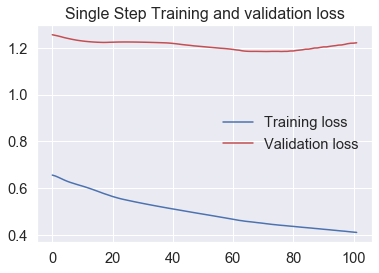

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
Run #1 : val_loss = 1.1981099797980317

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #2 : val_loss = 1.4091122751691767

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #3 : val_loss = 1.2933370460799818

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Run #4 : val_loss = 1.340404220493149

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #5 : val_loss = 1.3527973234289714

 Run #6
Restoring model weights from th

Run #11 : val_loss = 1.3105052753673978

 Run #12
Restoring model weights from the end of the best epoch.
Epoch 00128: early stopping
Run #12 : val_loss = 1.3952725057592072

 Run #13
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #13 : val_loss = 1.4305337501558864

 Run #14
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #14 : val_loss = 1.173635757746745


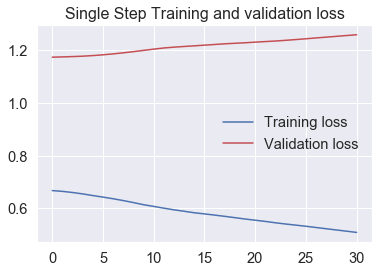

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #15
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #15 : val_loss = 1.4360919986487755

 Run #16
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Run #16 : val_loss = 1.3091251447187848

 Run #17
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #17 : val_loss = 1.3129586751895137

 Run #18
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #18 : val_loss = 1.276634080786828

 Run #19
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #19 : val_loss = 1.2317418256410786

 Run #20
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #20 : val_loss = 1.1274227120304592


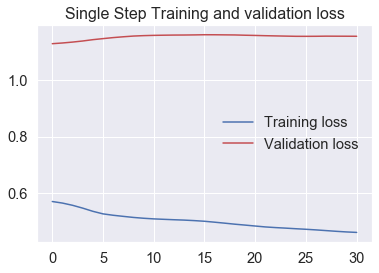

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #21
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #21 : val_loss = 1.491454575267566

 Run #22
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #22 : val_loss = 1.3489909496260264

 Run #23
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
Run #23 : val_loss = 1.2052019462556969

 Run #24
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
Run #24 : val_loss = 1.1586465072454342

 Run #25
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Run #25 : val_loss = 1.2555887938799448

 Run #26
Restoring model weights from the end of the best epoch.
Epoch 00143: early stopping
Run #26 : val_loss = 1.3524613753528723

 Run #27
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Run #27 : val_loss = 1.3866239167386

Run #30 : val_loss = 1.1847372698233851

 Run #31
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #31 : val_loss = 1.2527928489582725

 Run #32
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
Run #32 : val_loss = 1.2807465242789515

 Run #33
Restoring model weights from the end of the best epoch.
Epoch 00139: early stopping
Run #33 : val_loss = 1.316010989305509

 Run #34
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Run #34 : val_loss = 1.3024662507799842

 Run #35
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #35 : val_loss = 1.2924263770548738

 Run #36
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
Run #36 : val_loss = 1.2177954078055375

 Run #37
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
Run #37 : val_loss = 1.2391987715949693

 Run #38
Restoring mod

Run #40 : val_loss = 1.3144912049741873

 Run #41
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #41 : val_loss = 1.2788047120542654

 Run #42
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Run #42 : val_loss = 1.2674955903982388

 Run #43
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
Run #43 : val_loss = 1.251806227081401

 Run #44
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #44 : val_loss = 1.19275162660437

 Run #45
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #45 : val_loss = 1.245895896629376

 Run #46
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
Run #46 : val_loss = 1.3179727909722754

 Run #47
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
Run #47 : val_loss = 1.262233686922995

 Run #48
Restoring model w

Run #50 : val_loss = 1.4221253489574062

 Run #51
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #51 : val_loss = 1.5336720496983656

 Run #52
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Run #52 : val_loss = 1.2515157729489186

 Run #53
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Run #53 : val_loss = 1.3286846844115683

 Run #54
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
Run #54 : val_loss = 1.1983681321711668

 Run #55
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Run #55 : val_loss = 1.4662132132201844

 Run #56
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
Run #56 : val_loss = 1.2132178861504532

 Run #57
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #57 : val_loss = 1.3872843659468383

 Run #58
Restoring mo

Run #60 : val_loss = 1.245357387290282

 Run #61
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #61 : val_loss = 1.051134604247857


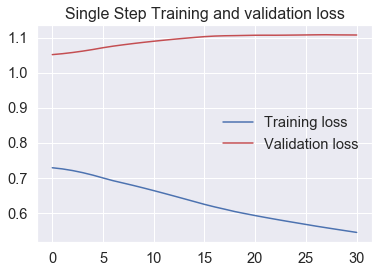

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #62
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #62 : val_loss = 1.416820680371897

 Run #63
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #63 : val_loss = 1.4947001976528593

 Run #64
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
Run #64 : val_loss = 1.2321452024029025

 Run #65
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Run #65 : val_loss = 1.5721054227521287

 Run #66
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Run #66 : val_loss = 1.1586591452216841

 Run #67
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Run #67 : val_loss = 1.3095924599896573

 Run #68
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Run #68 : val_loss = 1.4427467333720

Run #71 : val_loss = 1.3054402108734118

 Run #72
Restoring model weights from the end of the best epoch.
Epoch 00275: early stopping
Run #72 : val_loss = 0.9886074593886196


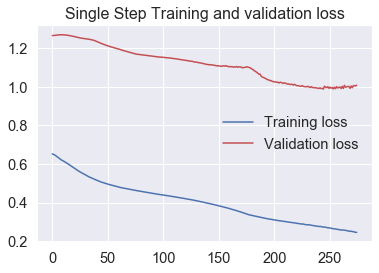

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #73
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #73 : val_loss = 1.2662779028616957

 Run #74
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
Run #74 : val_loss = 1.4058300000018829

 Run #75
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Run #75 : val_loss = 1.3817474267547407

 Run #76
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Run #76 : val_loss = 1.382688218318803

 Run #77
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
Run #77 : val_loss = 1.3167171576627918

 Run #78
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
Run #78 : val_loss = 1.3061735942596027

 Run #79
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #79 : val_loss = 1.2521373096809

Run #82 : val_loss = 1.3817270845742353

 Run #83
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Run #83 : val_loss = 1.1742296020822711

 Run #84
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
Run #84 : val_loss = 1.3461615703403407

 Run #85
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #85 : val_loss = 1.1490986991996057

 Run #86
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
Run #86 : val_loss = 1.248164758142961

 Run #87
Restoring model weights from the end of the best epoch.
Epoch 00145: early stopping
Run #87 : val_loss = 1.2045637091944106

 Run #88
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #88 : val_loss = 1.2912966611023915

 Run #89
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
Run #89 : val_loss = 1.514210102437941

 Run #90
Restoring mode

Run #92 : val_loss = 1.3018465630450398

 Run #93
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Run #93 : val_loss = 1.2867029333123394

 Run #94
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
Run #94 : val_loss = 1.3015274927587637

 Run #95
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Run #95 : val_loss = 1.2457997967125305

 Run #96
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #96 : val_loss = 1.2239466279136129

 Run #97
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
Run #97 : val_loss = 1.3482961617977747

 Run #98
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #98 : val_loss = 1.4410972828613051

 Run #99
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
Run #99 : val_loss = 1.2581899038617887

 Run #100
Restoring m

Run #102 : val_loss = 1.1710426390493403

 Run #103
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #103 : val_loss = 1.1860759972917028

 Run #104
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
Run #104 : val_loss = 1.4107199810875224

 Run #105
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
Run #105 : val_loss = 1.1795946612112336

 Run #106
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #106 : val_loss = 1.4627836043349856

 Run #107
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
Run #107 : val_loss = 1.506649776418639

 Run #108
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #108 : val_loss = 1.337240164457766

 Run #109
Restoring model weights from the end of the best epoch.
Epoch 00170: early stopping
Run #109 : val_loss = 1.18869987950748

 Run #110


Run #112 : val_loss = 1.320038160365952

 Run #113
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #113 : val_loss = 1.44603039609356

 Run #114
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Run #114 : val_loss = 1.4698686284443008

 Run #115
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Run #115 : val_loss = 1.2844417730668671

 Run #116
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Run #116 : val_loss = 1.3057804042330123

 Run #117
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Run #117 : val_loss = 1.2438652836574353

 Run #118
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #118 : val_loss = 1.2461520947838314

 Run #119
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Run #119 : val_loss = 1.3145438961786606

 Run #120

Run #122 : val_loss = 1.3621798683504218

 Run #123
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #123 : val_loss = 1.2713297387221285

 Run #124
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #124 : val_loss = 1.4380750030381062

 Run #125
Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping
Run #125 : val_loss = 1.328770132442882

 Run #126
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Run #126 : val_loss = 1.282590791756233

 Run #127
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #127 : val_loss = 1.193292011725355

 Run #128
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Run #128 : val_loss = 1.5541242021045387

 Run #129
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #129 : val_loss = 1.3060305365217961

 Run #130

Run #132 : val_loss = 1.3047933816546031

 Run #133
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #133 : val_loss = 1.3512610365272888

 Run #134
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Run #134 : val_loss = 1.382386042793227

 Run #135
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #135 : val_loss = 1.3635632854988256

 Run #136
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #136 : val_loss = 1.4509277238009142

 Run #137
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #137 : val_loss = 1.2698581182034143

 Run #138
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #138 : val_loss = 1.1974210624905415

 Run #139
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Run #139 : val_loss = 1.4193609294212999

 Run #1

Run #142 : val_loss = 1.0984658259534668

 Run #143
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Run #143 : val_loss = 1.4868729274218546

 Run #144
Restoring model weights from the end of the best epoch.
Epoch 00143: early stopping
Run #144 : val_loss = 1.1972397701451012

 Run #145
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
Run #145 : val_loss = 1.241109169610722

 Run #146
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #146 : val_loss = 1.1672877680832632

 Run #147
Restoring model weights from the end of the best epoch.
Epoch 00172: early stopping
Run #147 : val_loss = 1.4670811073435956

 Run #148
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #148 : val_loss = 1.281461392107524

 Run #149
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #149 : val_loss = 1.5443236195912229

 Run #15

Run #152 : val_loss = 1.3586435151375942

 Run #153
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #153 : val_loss = 1.427958102953566

 Run #154
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #154 : val_loss = 1.213350279475201

 Run #155
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #155 : val_loss = 1.2718051309915648

 Run #156
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #156 : val_loss = 1.191295939716149

 Run #157
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #157 : val_loss = 1.2317715373212583

 Run #158
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #158 : val_loss = 1.2469903536987137

 Run #159
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #159 : val_loss = 1.2522921108031757

 Run #160

Run #162 : val_loss = 1.2456423875977674

 Run #163
Restoring model weights from the end of the best epoch.
Epoch 00168: early stopping
Run #163 : val_loss = 1.2961963895344564

 Run #164
Restoring model weights from the end of the best epoch.
Epoch 00319: early stopping
Run #164 : val_loss = 0.9444938489665853


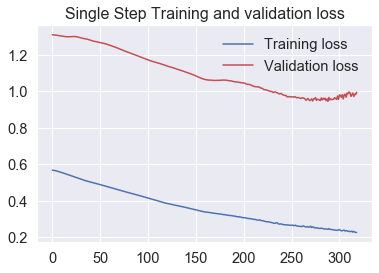

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #165
Restoring model weights from the end of the best epoch.
Epoch 00187: early stopping
Run #165 : val_loss = 1.1018023213693986

 Run #166
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #166 : val_loss = 1.2662200098260694

 Run #167
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Run #167 : val_loss = 1.3686466580824383

 Run #168
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
Run #168 : val_loss = 1.2257792803560772

 Run #169
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
Run #169 : val_loss = 1.2177063897819647

 Run #170
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Run #170 : val_loss = 1.4326641552019321

 Run #171
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
Run #171 : val_loss = 

Run #174 : val_loss = 1.06440764875771

 Run #175
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #175 : val_loss = 1.3396513322224952

 Run #176
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #176 : val_loss = 1.1204042055035122

 Run #177
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Run #177 : val_loss = 1.305572568779466

 Run #178
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
Run #178 : val_loss = 1.362810337972773

 Run #179
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #179 : val_loss = 1.2422898330116756

 Run #180
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
Run #180 : val_loss = 1.258621298066286

 Run #181
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #181 : val_loss = 1.300873731365066

 Run #182
Re

Run #183 : val_loss = 1.497081586216522

 Run #184
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #184 : val_loss = 1.2738383415257015

 Run #185
Restoring model weights from the end of the best epoch.
Epoch 00141: early stopping
Run #185 : val_loss = 1.1883139926796893

 Run #186
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
Run #186 : val_loss = 1.141591619918693

 Run #187
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Run #187 : val_loss = 1.3731496328822725

 Run #188
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Run #188 : val_loss = 1.1934175437638648

 Run #189
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #189 : val_loss = 1.5036156141629087

 Run #190
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Run #190 : val_loss = 1.3499599332557448

 Run #19

Run #193 : val_loss = 1.2856565106051154

 Run #194
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #194 : val_loss = 1.2369210005128868

 Run #195
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Run #195 : val_loss = 1.2985533808809162

 Run #196
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #196 : val_loss = 1.2979811796089091

 Run #197
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
Run #197 : val_loss = 1.216927465444535

 Run #198
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
Run #198 : val_loss = 1.4544975274672376

 Run #199
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
Run #199 : val_loss = 1.2188437704319246

 Run #200
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #200 : val_loss = 1.21247490051632

 Run #201

Run #203 : val_loss = 1.3168496454456933

 Run #204
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #204 : val_loss = 1.331388001445161

 Run #205
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Run #205 : val_loss = 1.3540706365005502

 Run #206
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #206 : val_loss = 1.2263656111756451

 Run #207
Restoring model weights from the end of the best epoch.
Epoch 00163: early stopping
Run #207 : val_loss = 0.9688743521095644

 Run #208
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
Run #208 : val_loss = 1.2035341162556894

 Run #209
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #209 : val_loss = 1.3561066561946102

 Run #210
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Run #210 : val_loss = 1.209583319010783

 Run #21

Run #213 : val_loss = 1.1828167193438315

 Run #214
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Run #214 : val_loss = 1.4987314567537435

 Run #215
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Run #215 : val_loss = 1.4836356570580431

 Run #216
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #216 : val_loss = 1.255050103049364

 Run #217
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Run #217 : val_loss = 1.310474461466951

 Run #218
Restoring model weights from the end of the best epoch.
Epoch 00225: early stopping
Run #218 : val_loss = 1.1441288195186685

 Run #219
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
Run #219 : val_loss = 1.2251918486133704

 Run #220
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #220 : val_loss = 1.3142888363074623

 Run #22

Run #223 : val_loss = 1.30038903542882

 Run #224
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #224 : val_loss = 1.3149171147817857

 Run #225
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
Run #225 : val_loss = 1.661421500282513

 Run #226
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #226 : val_loss = 1.304028522208903

 Run #227
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
Run #227 : val_loss = 1.4119371204273232

 Run #228
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #228 : val_loss = 1.3757160551016607

 Run #229
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
Run #229 : val_loss = 1.325022273288054

 Run #230
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #230 : val_loss = 1.234534859875787

 Run #231
Re

Run #233 : val_loss = 1.2177750591511018

 Run #234
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Run #234 : val_loss = 1.596789176632596

 Run #235
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #235 : val_loss = 1.474765917663511

 Run #236
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
Run #236 : val_loss = 1.1873104116681241

 Run #237
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #237 : val_loss = 1.1746980526806898

 Run #238
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
Run #238 : val_loss = 1.2764906129065545

 Run #239
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
Run #239 : val_loss = 1.30934979073791

 Run #240
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
Run #240 : val_loss = 1.2035301190191992

 Run #241


Run #243 : val_loss = 1.3098251396426388

 Run #244
Restoring model weights from the end of the best epoch.
Epoch 00195: early stopping
Run #244 : val_loss = 1.1346660969580733

 Run #245
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Run #245 : val_loss = 1.1710162442034222

 Run #246
Restoring model weights from the end of the best epoch.
Epoch 00210: early stopping
Run #246 : val_loss = 1.0857908402754293

 Run #247
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
Run #247 : val_loss = 1.4766439376966485

 Run #248
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #248 : val_loss = 1.2961342512266167

 Run #249
Restoring model weights from the end of the best epoch.
Epoch 00203: early stopping
Run #249 : val_loss = 1.153295425609734

 Run #250
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #250 : val_loss = 1.312048744932694

 Run #25

Run #253 : val_loss = 1.3005372908068278

 Run #254
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
Run #254 : val_loss = 1.1366764992111753

 Run #255
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Run #255 : val_loss = 1.276402514251826

 Run #256
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Run #256 : val_loss = 1.3864959538823665

 Run #257
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
Run #257 : val_loss = 1.250953896959258

 Run #258
Restoring model weights from the end of the best epoch.
Epoch 00146: early stopping
Run #258 : val_loss = 1.2024238428423295

 Run #259
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #259 : val_loss = 1.3488276559495755

 Run #260
Restoring model weights from the end of the best epoch.
Epoch 00138: early stopping
Run #260 : val_loss = 1.2221692521692642

 Run #26

Run #263 : val_loss = 1.2646409457651355

 Run #264
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Run #264 : val_loss = 1.3872786511851773

 Run #265
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
Run #265 : val_loss = 1.3418818939811938

 Run #266
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Run #266 : val_loss = 1.2964853851446994

 Run #267
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
Run #267 : val_loss = 1.4073773748808929

 Run #268
Restoring model weights from the end of the best epoch.
Epoch 00196: early stopping
Run #268 : val_loss = 1.5890084297446359

 Run #269
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Run #269 : val_loss = 1.2990925980122872

 Run #270
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
Run #270 : val_loss = 1.432584706750644

 Run #2

Run #273 : val_loss = 1.2313331889310963

 Run #274
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #274 : val_loss = 1.2250690741786845

 Run #275
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #275 : val_loss = 1.1924691565657146

 Run #276
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #276 : val_loss = 1.3417793112443217

 Run #277
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #277 : val_loss = 1.2380231267163642

 Run #278
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #278 : val_loss = 1.3926310164955833

 Run #279
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #279 : val_loss = 1.169416104661871

 Run #280
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Run #280 : val_loss = 1.3777613755279796

 Run #2

Run #283 : val_loss = 1.5681007505824431

 Run #284
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Run #284 : val_loss = 1.447441126742346

 Run #285
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
Run #285 : val_loss = 1.189643894540716

 Run #286
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #286 : val_loss = 1.1928954730831198

 Run #287
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
Run #287 : val_loss = 1.2959148954236337

 Run #288
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
Run #288 : val_loss = 1.265173449004946

 Run #289
Restoring model weights from the end of the best epoch.
Epoch 00218: early stopping
Run #289 : val_loss = 1.1747142284361944

 Run #290
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Run #290 : val_loss = 1.4470934328259357

 Run #291

Run #293 : val_loss = 1.2013618483310022

 Run #294
Restoring model weights from the end of the best epoch.
Epoch 00160: early stopping
Run #294 : val_loss = 1.205683593462167

 Run #295
Restoring model weights from the end of the best epoch.
Epoch 00207: early stopping
Run #295 : val_loss = 1.0668956406366379

 Run #296
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #296 : val_loss = 1.4218190890955196

 Run #297
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #297 : val_loss = 1.1783566067317612

 Run #298
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Run #298 : val_loss = 1.4020603470839017

 Run #299
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #299 : val_loss = 1.1266437221640833

 Run #300
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
Run #300 : val_loss = 1.223053017616842

 Run #30

Run #303 : val_loss = 1.2652845743434615

 Run #304
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
Run #304 : val_loss = 1.2472750587025114

 Run #305
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #305 : val_loss = 1.2969614520991333

 Run #306
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Run #306 : val_loss = 1.2119075467201061

 Run #307
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #307 : val_loss = 1.247392299758216

 Run #308
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #308 : val_loss = 1.409082910219153

 Run #309
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
Run #309 : val_loss = 1.1594113871091434

 Run #310
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
Run #310 : val_loss = 1.2302140515727567

 Run #31

Run #313 : val_loss = 1.1118425836177657

 Run #314
Restoring model weights from the end of the best epoch.
Epoch 00266: early stopping
Run #314 : val_loss = 1.0573076609569156

 Run #315
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #315 : val_loss = 1.2344441993484385

 Run #316
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #316 : val_loss = 1.2003275701412388

 Run #317
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #317 : val_loss = 1.1589789283297391

 Run #318
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #318 : val_loss = 1.233111362191487

 Run #319
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Run #319 : val_loss = 1.4124736409270593

 Run #320
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Run #320 : val_loss = 1.2794242580988833

 Run #3

Run #323 : val_loss = 1.3797085648970135

 Run #324
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
Run #324 : val_loss = 1.4126033193013185

 Run #325
Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
Run #325 : val_loss = 1.1467575524569877

 Run #326
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #326 : val_loss = 1.1820413896205015

 Run #327
Restoring model weights from the end of the best epoch.
Epoch 00152: early stopping
Run #327 : val_loss = 1.2819863427997955

 Run #328
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #328 : val_loss = 1.296836139691008

 Run #329
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Run #329 : val_loss = 1.2772890376494654

 Run #330
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
Run #330 : val_loss = 1.4419273158033954

 Run #3

Run #333 : val_loss = 1.2495272044522332

 Run #334
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #334 : val_loss = 1.3960687937782534

 Run #335
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Run #335 : val_loss = 1.2656017163021789

 Run #336
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
Run #336 : val_loss = 1.1524081619558313

 Run #337
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #337 : val_loss = 1.2840466178589889

 Run #338
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #338 : val_loss = 1.2378128283293375

 Run #339
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #339 : val_loss = 1.3243600216796079

 Run #340
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #340 : val_loss = 1.4050320335067266

 Run #

Run #343 : val_loss = 1.2099509809488542

 Run #344
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
Run #344 : val_loss = 1.311738292859813

 Run #345
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #345 : val_loss = 1.2613364510456488

 Run #346
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #346 : val_loss = 1.1855560049736984

 Run #347
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #347 : val_loss = 1.1664820501903184

 Run #348
Restoring model weights from the end of the best epoch.
Epoch 00159: early stopping
Run #348 : val_loss = 1.5378830772733987

 Run #349
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Run #349 : val_loss = 1.2867751589367278

 Run #350
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #350 : val_loss = 1.2931448001038395

 Run #3

Run #353 : val_loss = 1.313477522038959

 Run #354
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Run #354 : val_loss = 1.4681960503206977

 Run #355
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #355 : val_loss = 1.4083665107595191

 Run #356
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
Run #356 : val_loss = 1.3566736151100525

 Run #357
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #357 : val_loss = 1.3823423181296715

 Run #358
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Run #358 : val_loss = 1.3965083980569073

 Run #359
Restoring model weights from the end of the best epoch.
Epoch 00146: early stopping
Run #359 : val_loss = 1.2027831298621483

 Run #360
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #360 : val_loss = 1.273258181811256

 Run #36

Run #363 : val_loss = 1.3694592186351695

 Run #364
Restoring model weights from the end of the best epoch.
Epoch 00128: early stopping
Run #364 : val_loss = 1.5003593718563693

 Run #365
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #365 : val_loss = 1.3189611824331262

 Run #366
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
Run #366 : val_loss = 1.1632203266346939

 Run #367
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #367 : val_loss = 1.301756622326506

 Run #368
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #368 : val_loss = 1.2228019500473626

 Run #369
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #369 : val_loss = 1.2439142041696347

 Run #370
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #370 : val_loss = 1.4118424486936458

 Run #3

Run #373 : val_loss = 1.192038575405825

 Run #374
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Run #374 : val_loss = 1.2669887010563277

 Run #375
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #375 : val_loss = 1.4827044389079713

 Run #376
Restoring model weights from the end of the best epoch.
Epoch 00165: early stopping
Run #376 : val_loss = 1.178796186168624

 Run #377
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #377 : val_loss = 1.1626495711827762

 Run #378
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Run #378 : val_loss = 1.4480190971502491

 Run #379
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #379 : val_loss = 1.2773708703318722

 Run #380
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #380 : val_loss = 1.287888153674651

 Run #381

Run #383 : val_loss = 1.2321113641941377

 Run #384
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
Run #384 : val_loss = 1.3371927671236374

 Run #385
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Run #385 : val_loss = 1.2510819675502756

 Run #386
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Run #386 : val_loss = 1.4677597747053408

 Run #387
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #387 : val_loss = 1.2388681315207966

 Run #388
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
Run #388 : val_loss = 1.2406494477167183

 Run #389
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #389 : val_loss = 1.2889516070574634

 Run #390
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Run #390 : val_loss = 1.3997602603034505

 Run #

Run #393 : val_loss = 1.2421944873043724

 Run #394
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Run #394 : val_loss = 1.3908524984130093

 Run #395
Restoring model weights from the end of the best epoch.
Epoch 00196: early stopping
Run #395 : val_loss = 1.240807935041424

 Run #396
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Run #396 : val_loss = 1.2216997841009327

 Run #397
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #397 : val_loss = 1.2478005587911345

 Run #398
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
Run #398 : val_loss = 1.2885526689337023

 Run #399
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #399 : val_loss = 1.2761574119651802

 Run #400
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #400 : val_loss = 1.287903122589562

 Run #40

Run #403 : val_loss = 1.3127165372119673

 Run #404
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #404 : val_loss = 1.1774563074434288

 Run #405
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Run #405 : val_loss = 1.2423628533581383

 Run #406
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #406 : val_loss = 1.2943455052884407

 Run #407
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
Run #407 : val_loss = 1.3808657178291508

 Run #408
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
Run #408 : val_loss = 1.4511887115062603

 Run #409
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
Run #409 : val_loss = 1.2744632428368665

 Run #410
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #410 : val_loss = 1.4268317465306648

 Run #

Run #413 : val_loss = 1.2560741357141563

 Run #414
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #414 : val_loss = 1.3671397138954529

 Run #415
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Run #415 : val_loss = 1.4465417324667253

 Run #416
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Run #416 : val_loss = 1.340351930410547

 Run #417
Restoring model weights from the end of the best epoch.
Epoch 00132: early stopping
Run #417 : val_loss = 1.2334581509334426

 Run #418
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Run #418 : val_loss = 1.2760491468800343

 Run #419
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
Run #419 : val_loss = 1.308079063250629

 Run #420
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #420 : val_loss = 1.2479866507623267

 Run #42

Run #423 : val_loss = 1.3026763105156012

 Run #424
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Run #424 : val_loss = 1.2306375168831476

 Run #425
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #425 : val_loss = 1.462867328255383

 Run #426
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Run #426 : val_loss = 1.4873803482820855

 Run #427
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Run #427 : val_loss = 1.3371158045680838

 Run #428
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
Run #428 : val_loss = 1.3291110033736953

 Run #429
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
Run #429 : val_loss = 1.2645402951022722

 Run #430
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Run #430 : val_loss = 1.387322742548717

 Run #43

Run #433 : val_loss = 1.2110952579518237

 Run #434
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #434 : val_loss = 1.1387489542687423

 Run #435
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #435 : val_loss = 1.3908989834002607

 Run #436
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #436 : val_loss = 1.2690559367040284

 Run #437
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #437 : val_loss = 1.2836943194255621

 Run #438
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
Run #438 : val_loss = 1.2520019843344965

 Run #439
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
Run #439 : val_loss = 1.2089349367292055

 Run #440
Restoring model weights from the end of the best epoch.
Epoch 00231: early stopping
Run #440 : val_loss = 1.1460691034430095

 Run #

Run #443 : val_loss = 1.574644344994949

 Run #444
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Run #444 : val_loss = 1.3915241738417574

 Run #445
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
Run #445 : val_loss = 1.2232397148104683

 Run #446
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Run #446 : val_loss = 1.2684064293847808

 Run #447
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
Run #447 : val_loss = 1.1728738150416054

 Run #448
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #448 : val_loss = 1.3717909058017579

 Run #449
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Run #449 : val_loss = 1.240767366471339

 Run #450
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #450 : val_loss = 1.2186853319728859

 Run #45

Run #453 : val_loss = 1.2834077773347141

 Run #454
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #454 : val_loss = 1.2615451720179447

 Run #455
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Run #455 : val_loss = 1.2878139569060334

 Run #456
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
Run #456 : val_loss = 1.3142121718171162

 Run #457
Restoring model weights from the end of the best epoch.
Epoch 00206: early stopping
Run #457 : val_loss = 1.067939366270734

 Run #458
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #458 : val_loss = 1.2333070973256715

 Run #459
Run #459 : val_loss = 1.1331416547620783

 Run #460
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #460 : val_loss = 1.2020585320280976

 Run #461
Restoring model weights from the end of the best epoch.
Epoch 00066: early stoppi

Run #463 : val_loss = 1.1697429951602705

 Run #464
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #464 : val_loss = 1.2715951473204807

 Run #465
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #465 : val_loss = 1.4173536522124817

 Run #466
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #466 : val_loss = 1.3158266586399283

 Run #467
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
Run #467 : val_loss = 1.3454136662752756

 Run #468
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #468 : val_loss = 1.223666605292458

 Run #469
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Run #469 : val_loss = 1.5184405456727015

 Run #470
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #470 : val_loss = 1.2511538721012063

 Run #4

Run #473 : val_loss = 1.3502369949696043

 Run #474
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #474 : val_loss = 1.2366543740356453

 Run #475
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #475 : val_loss = 1.350498805810643

 Run #476
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #476 : val_loss = 1.2670645147884376

 Run #477
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
Run #477 : val_loss = 1.2858121677403727

 Run #478
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
Run #478 : val_loss = 1.3126657782690057

 Run #479
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Run #479 : val_loss = 1.1832762367414422

 Run #480
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
Run #480 : val_loss = 1.4200746285693364

 Run #4

Run #483 : val_loss = 1.399341181210188

 Run #484
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #484 : val_loss = 1.2697260414572544

 Run #485
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #485 : val_loss = 1.2672398926081248

 Run #486
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #486 : val_loss = 1.310469553202204

 Run #487
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
Run #487 : val_loss = 1.3304609914179348

 Run #488
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Run #488 : val_loss = 1.1847224787199981

 Run #489
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
Run #489 : val_loss = 1.3428970845983752

 Run #490
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
Run #490 : val_loss = 1.302563937482994

 Run #491

Run #493 : val_loss = 1.3043686800505423

 Run #494
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #494 : val_loss = 1.3312853301744365

 Run #495
Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
Run #495 : val_loss = 1.181198525111761

 Run #496
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #496 : val_loss = 1.2495577372467257

 Run #497
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
Run #497 : val_loss = 1.2466204572105237

 Run #498
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
Run #498 : val_loss = 1.1937532388241419

 Run #499
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
Run #499 : val_loss = 1.2838316196432449

 Run #500
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #500 : val_loss = 1.2351479253122695

 Run #5

Run #503 : val_loss = 1.2224562207559235

 Run #504
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #504 : val_loss = 1.3497112556928226

 Run #505
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #505 : val_loss = 1.3972423258805104

 Run #506
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #506 : val_loss = 1.1693679045276828

 Run #507
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Run #507 : val_loss = 1.390323072845062

 Run #508
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
Run #508 : val_loss = 1.4558462803819605

 Run #509
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
Run #509 : val_loss = 1.2226841940866895

 Run #510
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Run #510 : val_loss = 1.334865737459261

 Run #51

Run #513 : val_loss = 1.380158797428889

 Run #514
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
Run #514 : val_loss = 1.2476335061350294

 Run #515
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
Run #515 : val_loss = 1.3696371502290035

 Run #516
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #516 : val_loss = 1.2337452489739396

 Run #517
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Run #517 : val_loss = 1.2691117446505853

 Run #518
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Run #518 : val_loss = 1.3814393645720013

 Run #519
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Run #519 : val_loss = 1.1534448836321123

 Run #520
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Run #520 : val_loss = 1.352098272704465

 Run #52

Run #523 : val_loss = 1.4599870804799178

 Run #524
Restoring model weights from the end of the best epoch.
Epoch 00124: early stopping
Run #524 : val_loss = 1.1455293619641493

 Run #525
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Run #525 : val_loss = 1.3002925594904848

 Run #526
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #526 : val_loss = 1.2065257555661835

 Run #527
Run #527 : val_loss = 1.0122970721348583

 Run #528
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #528 : val_loss = 1.310485687862096

 Run #529
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Run #529 : val_loss = 1.2659481352297046

 Run #530
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Run #530 : val_loss = 1.3356924611711332

 Run #531
Restoring model weights from the end of the best epoch.
Epoch 00305: early stoppi

Run #533 : val_loss = 1.267635882947074

 Run #534
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Run #534 : val_loss = 1.2461685608708688

 Run #535
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
Run #535 : val_loss = 1.24470757722011

 Run #536
Restoring model weights from the end of the best epoch.
Epoch 00186: early stopping
Run #536 : val_loss = 1.1872866615454876

 Run #537
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #537 : val_loss = 1.5476155793861874

 Run #538
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Run #538 : val_loss = 1.4885280365691909

 Run #539
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #539 : val_loss = 1.383315671350287

 Run #540
Restoring model weights from the end of the best epoch.
Epoch 00240: early stopping
Run #540 : val_loss = 1.46141637255463

 Run #541
Re

Run #543 : val_loss = 1.5235034501227105

 Run #544
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
Run #544 : val_loss = 1.2410485977874526

 Run #545
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Run #545 : val_loss = 1.3305837060892411

 Run #546
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
Run #546 : val_loss = 1.2201667253250368

 Run #547
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
Run #547 : val_loss = 1.331708076815998

 Run #548
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #548 : val_loss = 1.1908211849952228

 Run #549
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #549 : val_loss = 1.5923081115455755

 Run #550
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Run #550 : val_loss = 1.1264385778779276

 Run #5

Run #553 : val_loss = 1.3678785270880365

 Run #554
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
Run #554 : val_loss = 1.2907112455563077

 Run #555
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Run #555 : val_loss = 1.3654110865303704

 Run #556
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #556 : val_loss = 1.1837142852457352

 Run #557
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Run #557 : val_loss = 1.2662188617834933

 Run #558
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Run #558 : val_loss = 1.2412131548774075

 Run #559
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #559 : val_loss = 1.286109323670102

 Run #560
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Run #560 : val_loss = 1.2428180577102506

 Run #5

Run #563 : val_loss = 1.340061191060526

 Run #564
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
Run #564 : val_loss = 1.3028375846901366

 Run #565
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #565 : val_loss = 1.396927484833581

 Run #566
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
Run #566 : val_loss = 1.3254332419586756

 Run #567
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Run #567 : val_loss = 1.203085815752495

 Run #568
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
Run #568 : val_loss = 1.2002318857560046

 Run #569
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #569 : val_loss = 1.3886295238611677

 Run #570
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #570 : val_loss = 1.316901098223973

 Run #571


Run #573 : val_loss = 1.2157359762206785

 Run #574
Restoring model weights from the end of the best epoch.
Epoch 00136: early stopping
Run #574 : val_loss = 1.4438744658240505

 Run #575
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Run #575 : val_loss = 1.2790964181171187

 Run #576
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #576 : val_loss = 1.3280648430794866

 Run #577
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
Run #577 : val_loss = 1.4542726763160356

 Run #578
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
Run #578 : val_loss = 1.5456460827460157

 Run #579
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #579 : val_loss = 1.2541023977668413

 Run #580
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
Run #580 : val_loss = 1.2499242441119738

 Run #

Run #583 : val_loss = 1.4894574806661733

 Run #584
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
Run #584 : val_loss = 1.3249055087202617

 Run #585
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
Run #585 : val_loss = 1.232140102480484

 Run #586
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
Run #586 : val_loss = 1.4644373349344002

 Run #587
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Run #587 : val_loss = 1.212198518855443

 Run #588
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
Run #588 : val_loss = 1.3926218440953286

 Run #589
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
Run #589 : val_loss = 1.224284909185592

 Run #590
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Run #590 : val_loss = 1.205044893766392

 Run #591


Run #593 : val_loss = 1.4858257016734608

 Run #594
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
Run #594 : val_loss = 1.127881306907732

 Run #595
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Run #595 : val_loss = 1.4291790938572415

 Run #596
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Run #596 : val_loss = 1.3044411025332399

 Run #597
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Run #597 : val_loss = 1.4129809740101376

 Run #598
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
Run #598 : val_loss = 1.2045676072450466

 Run #599
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Run #599 : val_loss = 1.2955956749940403

 Run #600
Run #600 : val_loss = 1.2579134377838683

 Run #601
Restoring model weights from the end of the best epoch.
Epoch 00031: early stoppi

Run #603 : val_loss = 1.3098822492742368

 Run #604
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
Run #604 : val_loss = 1.4271783130152822

 Run #605
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Run #605 : val_loss = 1.3407263107350484

 Run #606
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Run #606 : val_loss = 1.216578133157093

 Run #607
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Run #607 : val_loss = 1.3466420749304273

 Run #608
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #608 : val_loss = 1.139404541287517

 Run #609
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #609 : val_loss = 1.3848145125070044

 Run #610
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #610 : val_loss = 1.2752488793196268

 Run #61

Run #613 : val_loss = 1.2431577677474746

 Run #614
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #614 : val_loss = 1.3460431184779775

 Run #615
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #615 : val_loss = 1.277432087328855

 Run #616
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #616 : val_loss = 1.2494400460840591

 Run #617
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #617 : val_loss = 1.2248894830556698

 Run #618
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Run #618 : val_loss = 1.305043016617132

 Run #619
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #619 : val_loss = 1.3354565452886202

 Run #620
Restoring model weights from the end of the best epoch.
Epoch 00348: early stopping
Run #620 : val_loss = 0.9876588974004724

 Run #62

Run #623 : val_loss = 1.3682842982801997

 Run #624
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Run #624 : val_loss = 1.304836470619414

 Run #625
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
Run #625 : val_loss = 1.2493261976036631

 Run #626
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #626 : val_loss = 1.3823211049297282

 Run #627
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
Run #627 : val_loss = 1.2605259130345114

 Run #628
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
Run #628 : val_loss = 1.2185052775168903

 Run #629
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #629 : val_loss = 1.4027530069564857

 Run #630
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #630 : val_loss = 1.2159272648716457

 Run #6

Run #633 : val_loss = 1.2847291868968047

 Run #634
Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
Run #634 : val_loss = 1.1840735520803758

 Run #635
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Run #635 : val_loss = 1.3680389046060033

 Run #636
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Run #636 : val_loss = 1.284270864431385

 Run #637
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
Run #637 : val_loss = 1.305726811973948

 Run #638
Restoring model weights from the end of the best epoch.
Epoch 00242: early stopping
Run #638 : val_loss = 1.3434181775944793

 Run #639
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #639 : val_loss = 1.3900049513307788

 Run #640
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Run #640 : val_loss = 1.2977655226990503

 Run #64

Run #643 : val_loss = 1.2810217328937181

 Run #644
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #644 : val_loss = 1.296004818039585

 Run #645
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #645 : val_loss = 1.2610845039455332

 Run #646
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #646 : val_loss = 1.3793938756556638

 Run #647
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Run #647 : val_loss = 1.301832594499869

 Run #648
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Run #648 : val_loss = 1.296696505100412

 Run #649
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Run #649 : val_loss = 1.2965201433384248

 Run #650
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Run #650 : val_loss = 1.3439674664390662

 Run #651

Run #653 : val_loss = 1.2133818325222858

 Run #654
Restoring model weights from the end of the best epoch.
Epoch 00240: early stopping
Run #654 : val_loss = 1.082352707219256

 Run #655
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #655 : val_loss = 1.2668388681342937

 Run #656
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #656 : val_loss = 1.383827115233002

 Run #657
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
Run #657 : val_loss = 1.2108253885382898

 Run #658
Restoring model weights from the end of the best epoch.
Epoch 00154: early stopping
Run #658 : val_loss = 1.2963156358440795

 Run #659
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Run #659 : val_loss = 1.3221767174402363

 Run #660
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
Run #660 : val_loss = 1.2804008619716503

 Run #66

Run #663 : val_loss = 1.2641860208808833

 Run #664
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Run #664 : val_loss = 1.2534407090718038

 Run #665
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #665 : val_loss = 1.2700464428038725

 Run #666
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #666 : val_loss = 1.249015349007316

 Run #667
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
Run #667 : val_loss = 1.4532177319248782

 Run #668
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #668 : val_loss = 1.2671997325817235

 Run #669
Restoring model weights from the end of the best epoch.
Epoch 00160: early stopping
Run #669 : val_loss = 1.2233528853961655

 Run #670
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
Run #670 : val_loss = 1.3604105725520679

 Run #6

Run #673 : val_loss = 1.3071733775870986

 Run #674
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #674 : val_loss = 1.2996386797606125

 Run #675
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #675 : val_loss = 1.3439815361620315

 Run #676
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Run #676 : val_loss = 1.50016221316619

 Run #677
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #677 : val_loss = 1.3175413387929478

 Run #678
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
Run #678 : val_loss = 1.2348487410330602

 Run #679
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
Run #679 : val_loss = 1.2549143415511974

 Run #680
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Run #680 : val_loss = 1.3476715004639157

 Run #68

Run #683 : val_loss = 1.5710050222893819

 Run #684
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
Run #684 : val_loss = 1.4033085955874451

 Run #685
Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
Run #685 : val_loss = 1.2838026029625365

 Run #686
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #686 : val_loss = 1.4771996103794702

 Run #687
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #687 : val_loss = 1.2196733883904405

 Run #688
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
Run #688 : val_loss = 1.214707762766473

 Run #689
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #689 : val_loss = 1.3053256824934967

 Run #690
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #690 : val_loss = 1.2854675544062086

 Run #6

Run #693 : val_loss = 1.1973174211438202

 Run #694
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
Run #694 : val_loss = 1.2110788028789141

 Run #695
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Run #695 : val_loss = 1.2677413870682397

 Run #696
Restoring model weights from the end of the best epoch.
Epoch 00197: early stopping
Run #696 : val_loss = 1.094833496316282

 Run #697
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #697 : val_loss = 1.3052385085322773

 Run #698
Run #698 : val_loss = 1.0521881447496007

 Run #699
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Run #699 : val_loss = 1.2522215305218585

 Run #700
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Run #700 : val_loss = 1.3310053316512533

 Run #701
Restoring model weights from the end of the best epoch.
Epoch 00041: early stoppi

Run #703 : val_loss = 1.3643809655317494

 Run #704
Restoring model weights from the end of the best epoch.
Epoch 00187: early stopping
Run #704 : val_loss = 1.416715875724584

 Run #705
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #705 : val_loss = 1.3484858307623693

 Run #706
Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
Run #706 : val_loss = 1.22996810247278

 Run #707
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Run #707 : val_loss = 1.2041007981026657

 Run #708
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #708 : val_loss = 1.4094284410224684

 Run #709
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Run #709 : val_loss = 1.3921870930338667

 Run #710
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
Run #710 : val_loss = 1.453187168021735

 Run #711


Run #713 : val_loss = 1.3059009824050047

 Run #714
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #714 : val_loss = 1.5011382365097867

 Run #715
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Run #715 : val_loss = 1.2373504660194197

 Run #716
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
Run #716 : val_loss = 1.368310849239064

 Run #717
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #717 : val_loss = 1.4114225795478017

 Run #718
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Run #718 : val_loss = 1.2915725870392674

 Run #719
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Run #719 : val_loss = 1.3856562208369763

 Run #720
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
Run #720 : val_loss = 1.2983294791178235

 Run #7

Run #723 : val_loss = 1.376892609927749

 Run #724
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
Run #724 : val_loss = 1.2738506096051463

 Run #725
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Run #725 : val_loss = 1.3700900660463997

 Run #726
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Run #726 : val_loss = 1.2081995347837098

 Run #727
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Run #727 : val_loss = 1.1258496690863855

 Run #728
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Run #728 : val_loss = 1.2138685503145137

 Run #729
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Run #729 : val_loss = 1.4641079211051315

 Run #730
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
Run #730 : val_loss = 1.3079615957671233

 Run #7

Run #733 : val_loss = 1.275370357019931

 Run #734
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #734 : val_loss = 1.418783067316694

 Run #735
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #735 : val_loss = 1.3355097037841954

 Run #736
Restoring model weights from the end of the best epoch.
Epoch 00133: early stopping
Run #736 : val_loss = 1.1922716752017029

 Run #737
Restoring model weights from the end of the best epoch.
Epoch 00169: early stopping
Run #737 : val_loss = 1.1745692260885723

 Run #738
Restoring model weights from the end of the best epoch.
Epoch 00179: early stopping
Run #738 : val_loss = 1.2068693185189383

 Run #739
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Run #739 : val_loss = 1.2188546543331928

 Run #740
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
Run #740 : val_loss = 1.2478762452812977

 Run #74

Run #743 : val_loss = 1.2432274252045357

 Run #744
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
Run #744 : val_loss = 1.5964068467638195

 Run #745
Restoring model weights from the end of the best epoch.
Epoch 00200: early stopping
Run #745 : val_loss = 1.2493810961590537

 Run #746
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Run #746 : val_loss = 1.3681903649689087

 Run #747
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Run #747 : val_loss = 1.2746720086419412

 Run #748
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #748 : val_loss = 1.3419441860736736

 Run #749
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
Run #749 : val_loss = 1.2771227572215178

 Run #750
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #750 : val_loss = 1.2802368440754823

 Run #

Run #753 : val_loss = 1.3003559802295097

 Run #754
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
Run #754 : val_loss = 1.4799182692644575

 Run #755
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
Run #755 : val_loss = 1.2687634829396026

 Run #756
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
Run #756 : val_loss = 1.293059612622896

 Run #757
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Run #757 : val_loss = 1.3557567288132029

 Run #758
Restoring model weights from the end of the best epoch.
Epoch 00266: early stopping
Run #758 : val_loss = 1.186664343402667

 Run #759
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
Run #759 : val_loss = 1.3407865716712006

 Run #760
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #760 : val_loss = 1.2983504137812294

 Run #76

Run #763 : val_loss = 1.3840749379291122

 Run #764
Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping
Run #764 : val_loss = 1.1835463764713534

 Run #765
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #765 : val_loss = 1.3987076329052837

 Run #766
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #766 : val_loss = 1.2795188123056893

 Run #767
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #767 : val_loss = 1.3122002459698745

 Run #768
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Run #768 : val_loss = 1.3790092363764455

 Run #769
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #769 : val_loss = 1.48968416644348

 Run #770
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Run #770 : val_loss = 1.2066097382778413

 Run #77

Run #773 : val_loss = 1.3241963930925

 Run #774
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #774 : val_loss = 1.36285493132746

 Run #775
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
Run #775 : val_loss = 1.2493730360278317

 Run #776
Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping
Run #776 : val_loss = 1.2421401513842323

 Run #777
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #777 : val_loss = 1.2563887896105759

 Run #778
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Run #778 : val_loss = 1.4488228398244285

 Run #779
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Run #779 : val_loss = 1.2812334212343597

 Run #780
Restoring model weights from the end of the best epoch.
Epoch 00238: early stopping
Run #780 : val_loss = 0.9317572549237823


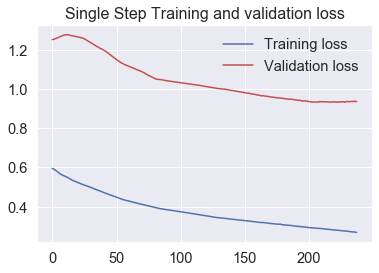

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #781
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #781 : val_loss = 1.281194081457436

 Run #782
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #782 : val_loss = 1.2339457422933653

 Run #783
Restoring model weights from the end of the best epoch.
Epoch 00358: early stopping
Run #783 : val_loss = 1.066111073195778

 Run #784
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #784 : val_loss = 1.2660408326630592

 Run #785
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
Run #785 : val_loss = 1.2302069076671653

 Run #786
Restoring model weights from the end of the best epoch.
Epoch 00231: early stopping
Run #786 : val_loss = 1.0202442156718503

 Run #787
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #787 : val_loss = 1.

Run #790 : val_loss = 1.2316737950170524

 Run #791
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #791 : val_loss = 1.3601040007636063

 Run #792
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #792 : val_loss = 1.3731786547563427

 Run #793
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Run #793 : val_loss = 1.1948902338612282

 Run #794
Restoring model weights from the end of the best epoch.
Epoch 00225: early stopping
Run #794 : val_loss = 1.053941375953194

 Run #795
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #795 : val_loss = 1.2770703153786638

 Run #796
Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping
Run #796 : val_loss = 1.2147134557584691

 Run #797
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
Run #797 : val_loss = 1.3829610949018427

 Run #7

Run #799 : val_loss = 1.3453760510878094

 Run #800
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Run #800 : val_loss = 1.3988772989818283

 Run #801
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Run #801 : val_loss = 1.2557390355361737

 Run #802
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
Run #802 : val_loss = 1.2434575094232447

 Run #803
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #803 : val_loss = 1.5331348636151867

 Run #804
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #804 : val_loss = 1.2320439151519555

 Run #805
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #805 : val_loss = 1.2365037244601287

 Run #806
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #806 : val_loss = 1.1915819824064262

 Run #

Run #809 : val_loss = 1.2514733756528624

 Run #810
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Run #810 : val_loss = 1.1992905151421316

 Run #811
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
Run #811 : val_loss = 1.2492247725007513

 Run #812
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Run #812 : val_loss = 1.2128491385230906

 Run #813
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Run #813 : val_loss = 1.2260060282991656

 Run #814
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Run #814 : val_loss = 1.2764220957746186

 Run #815
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Run #815 : val_loss = 1.299400466143565

 Run #816
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
Run #816 : val_loss = 1.3443596587152609

 Run #8

Run #819 : val_loss = 1.1388526561061032

 Run #820
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #820 : val_loss = 1.3508920966400222

 Run #821
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
Run #821 : val_loss = 1.363725826666636

 Run #822
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
Run #822 : val_loss = 1.3004348837406763

 Run #823
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #823 : val_loss = 1.1418555669808874

 Run #824
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Run #824 : val_loss = 1.3236005951041467

 Run #825
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #825 : val_loss = 1.3101594194160886

 Run #826
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
Run #826 : val_loss = 1.4466852448516914

 Run #8

Run #829 : val_loss = 1.166369079830695

 Run #830
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Run #830 : val_loss = 1.3515176601344177

 Run #831
Restoring model weights from the end of the best epoch.
Epoch 00397: early stopping
Run #831 : val_loss = 1.236493753646549

 Run #832
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #832 : val_loss = 1.3259725036189072

 Run #833
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #833 : val_loss = 1.4211399723411926

 Run #834
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #834 : val_loss = 1.257838422883872

 Run #835
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
Run #835 : val_loss = 1.2894659455829875

 Run #836
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Run #836 : val_loss = 1.2531672606113755

 Run #837

Run #839 : val_loss = 1.2848411747821995

 Run #840
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
Run #840 : val_loss = 1.139635818842642

 Run #841
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Run #841 : val_loss = 1.168001414495159

 Run #842
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #842 : val_loss = 1.3435506325317004

 Run #843
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #843 : val_loss = 1.2125379687497504

 Run #844
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
Run #844 : val_loss = 1.2600775660816037

 Run #845
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #845 : val_loss = 1.2199736761251576

 Run #846
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Run #846 : val_loss = 1.344601120390875

 Run #847

Run #849 : val_loss = 1.2719879393102058

 Run #850
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
Run #850 : val_loss = 1.3823755769393795

 Run #851
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Run #851 : val_loss = 1.3194395625600048

 Run #852
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
Run #852 : val_loss = 1.2901446889722177

 Run #853
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
Run #853 : val_loss = 1.2921499545322188

 Run #854
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #854 : val_loss = 1.2253849294358976

 Run #855
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #855 : val_loss = 1.2742871984941342

 Run #856
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Run #856 : val_loss = 1.5032398563911595

 Run #

Run #859 : val_loss = 1.1707023123601563

 Run #860
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
Run #860 : val_loss = 1.467380870132187

 Run #861
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
Run #861 : val_loss = 1.1963583479957767

 Run #862
Restoring model weights from the end of the best epoch.
Epoch 00116: early stopping
Run #862 : val_loss = 1.230861993259389

 Run #863
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #863 : val_loss = 1.287093940131312

 Run #864
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #864 : val_loss = 1.6038150837691987

 Run #865
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
Run #865 : val_loss = 1.1852638721322755

 Run #866
Restoring model weights from the end of the best epoch.
Epoch 00116: early stopping
Run #866 : val_loss = 1.3507736554005572

 Run #867

Run #869 : val_loss = 1.3466476039597222

 Run #870
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #870 : val_loss = 1.444416173324866

 Run #871
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #871 : val_loss = 1.387320614476634

 Run #872
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #872 : val_loss = 1.2408416585387774

 Run #873
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #873 : val_loss = 1.5049223910515772

 Run #874
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #874 : val_loss = 1.4711867517523112

 Run #875
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #875 : val_loss = 1.2404907469028719

 Run #876
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #876 : val_loss = 1.310179285761846

 Run #877

Run #879 : val_loss = 1.1149610924170743

 Run #880
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Run #880 : val_loss = 1.4487555112188326

 Run #881
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
Run #881 : val_loss = 1.3074615854406186

 Run #882
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #882 : val_loss = 1.3547817250803225

 Run #883
Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Run #883 : val_loss = 1.1794596051188297

 Run #884
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
Run #884 : val_loss = 1.2735555354935693

 Run #885
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
Run #885 : val_loss = 1.3282966027603873

 Run #886
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Run #886 : val_loss = 1.2678717202363647

 Run #

Run #889 : val_loss = 1.3004972169277647

 Run #890
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Run #890 : val_loss = 1.2167891536230333

 Run #891
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #891 : val_loss = 1.178807112141151

 Run #892
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Run #892 : val_loss = 1.3684537041685

 Run #893
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #893 : val_loss = 1.4697443650206008

 Run #894
Restoring model weights from the end of the best epoch.
Epoch 00132: early stopping
Run #894 : val_loss = 1.2882506413432324

 Run #895
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
Run #895 : val_loss = 1.3244811064199933

 Run #896
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
Run #896 : val_loss = 1.2708135624983736

 Run #897


Run #899 : val_loss = 1.2417820375980266

 Run #900
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Run #900 : val_loss = 1.3956314903320202

 Run #901
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Run #901 : val_loss = 1.2821863216670342

 Run #902
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Run #902 : val_loss = 1.4740250540395843

 Run #903
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #903 : val_loss = 1.2275557537199386

 Run #904
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #904 : val_loss = 1.3194730747476608

 Run #905
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #905 : val_loss = 1.334790276303833

 Run #906
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
Run #906 : val_loss = 1.2066094778114387

 Run #9

Run #909 : val_loss = 1.0682765390231388

 Run #910
Restoring model weights from the end of the best epoch.
Epoch 00124: early stopping
Run #910 : val_loss = 1.284744972885532

 Run #911
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #911 : val_loss = 1.2597757025653142

 Run #912
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Run #912 : val_loss = 1.250231134225253

 Run #913
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
Run #913 : val_loss = 1.5219425429226288

 Run #914
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Run #914 : val_loss = 1.515591941910015

 Run #915
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #915 : val_loss = 1.4375322385443763

 Run #916
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
Run #916 : val_loss = 1.3393335368586161

 Run #917

Run #919 : val_loss = 1.2381254005580598

 Run #920
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Run #920 : val_loss = 1.432803252848016

 Run #921
Restoring model weights from the end of the best epoch.
Epoch 00139: early stopping
Run #921 : val_loss = 1.2550552087472209

 Run #922
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #922 : val_loss = 1.2587336118434944

 Run #923
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #923 : val_loss = 1.226120899649907

 Run #924
Restoring model weights from the end of the best epoch.
Epoch 00090: early stopping
Run #924 : val_loss = 1.4365605423794516

 Run #925
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #925 : val_loss = 1.1462796630660184

 Run #926
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Run #926 : val_loss = 1.268042256342817

 Run #927

Run #929 : val_loss = 0.9261448720997711


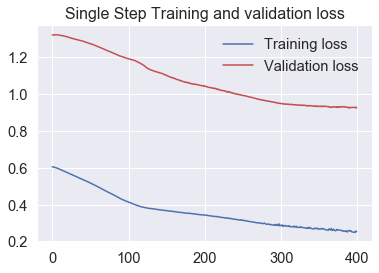

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #930
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
Run #930 : val_loss = 1.235072760899497

 Run #931
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #931 : val_loss = 1.525927166045589

 Run #932
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Run #932 : val_loss = 1.3297682272372224

 Run #933
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Run #933 : val_loss = 1.3374142535598406

 Run #934
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Run #934 : val_loss = 1.3120992540483751

 Run #935
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #935 : val_loss = 1.3999111629658767

 Run #936
Run #936 : val_loss = 0.883235725792695


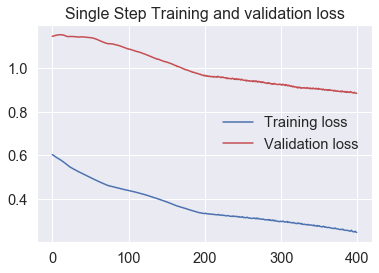

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr/assets

 Run #937
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
Run #937 : val_loss = 1.2583747315788099

 Run #938
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Run #938 : val_loss = 1.264717399361182

 Run #939
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #939 : val_loss = 1.262905959258426

 Run #940
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Run #940 : val_loss = 1.450452970630435

 Run #941
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #941 : val_loss = 1.2371408941546567

 Run #942
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
Run #942 : val_loss = 1.291483201222645

 Run #943
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Run #943 : val_loss = 1.36

Run #946 : val_loss = 1.1429648285916374

 Run #947
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #947 : val_loss = 1.1780759566320218

 Run #948
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #948 : val_loss = 1.3142802194328436

 Run #949
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Run #949 : val_loss = 1.4176537544102796

 Run #950
Restoring model weights from the end of the best epoch.
Epoch 00138: early stopping
Run #950 : val_loss = 1.5095030921420753

 Run #951
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
Run #951 : val_loss = 1.304641033579541

 Run #952
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #952 : val_loss = 1.4181306912199982

 Run #953
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Run #953 : val_loss = 1.4230063090202787

 Run #9

Run #955 : val_loss = 1.216531459460605

 Run #956
Restoring model weights from the end of the best epoch.
Epoch 00345: early stopping
Run #956 : val_loss = 0.9637055093469584

 Run #957
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #957 : val_loss = 1.1060276434147844

 Run #958
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #958 : val_loss = 1.2667886503608354

 Run #959
Restoring model weights from the end of the best epoch.
Epoch 00146: early stopping
Run #959 : val_loss = 1.2129854862434901

 Run #960
Restoring model weights from the end of the best epoch.
Epoch 00087: early stopping
Run #960 : val_loss = 1.3756821500705012

 Run #961
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Run #961 : val_loss = 1.293218931822052

 Run #962
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #962 : val_loss = 1.1183991025303879

 Run #96

Run #965 : val_loss = 1.2921164830188379

 Run #966
Restoring model weights from the end of the best epoch.
Epoch 00235: early stopping
Run #966 : val_loss = 1.0568019250044058

 Run #967
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Run #967 : val_loss = 1.3945284608250128

 Run #968
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Run #968 : val_loss = 1.3673549835206398

 Run #969
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
Run #969 : val_loss = 1.2638167939716407

 Run #970
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #970 : val_loss = 1.3375217556589671

 Run #971
Restoring model weights from the end of the best epoch.
Epoch 00273: early stopping
Run #971 : val_loss = 0.9022257544627925

 Run #972
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #972 : val_loss = 1.2064707507946917

 Run #

Run #975 : val_loss = 1.4328650100203717

 Run #976
Restoring model weights from the end of the best epoch.
Epoch 00189: early stopping
Run #976 : val_loss = 1.0961295348228346

 Run #977
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #977 : val_loss = 1.3021805378943139

 Run #978
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #978 : val_loss = 1.1272498436594496

 Run #979
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Run #979 : val_loss = 1.2432157553123422

 Run #980
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
Run #980 : val_loss = 1.271872298499515

 Run #981
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Run #981 : val_loss = 1.318461329267306

 Run #982
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #982 : val_loss = 1.3989685027907157

 Run #98

Run #985 : val_loss = 1.2308197601089366

 Run #986
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Run #986 : val_loss = 1.1426586129093654

 Run #987
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Run #987 : val_loss = 1.2123742180978336

 Run #988
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Run #988 : val_loss = 1.4747598343438209

 Run #989
Restoring model weights from the end of the best epoch.
Epoch 00158: early stopping
Run #989 : val_loss = 1.231535958648605

 Run #990
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #990 : val_loss = 1.3837126368292996

 Run #991
Restoring model weights from the end of the best epoch.
Epoch 00221: early stopping
Run #991 : val_loss = 1.048108660207076

 Run #992
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #992 : val_loss = 1.2817537091308662

 Run #99

Run #995 : val_loss = 1.1304922698898494

 Run #996
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #996 : val_loss = 1.274848550731262

 Run #997
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #997 : val_loss = 1.2864929427598715

 Run #998
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #998 : val_loss = 1.268844374674011

 Run #999
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #999 : val_loss = 1.244887403269244
CPU times: user 1h 4min 10s, sys: 6min 44s, total: 1h 10min 54s
Wall time: 1h 3min 9s


In [74]:
%%time
NB_TRY = 1000
EVALUATION_INTERVAL = 1
EPOCHS = 400
# Hyper-parameters
lr = 1e-2
decay = 1e-6
momentum = 0.9
nesterov = True 

sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov) 

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=30,
                                   restore_best_weights=True)


list_loss = []

for I in range(NB_TRY):
    print("")
    print(f" Run #{I}")
    single_step_model = tf.keras.models.Sequential()

    '''single_step_model.add(tf.keras.layers.LSTM(4, return_sequences=True,
                                            input_shape=x_train_single.shape[-2:]))

    single_step_model.add(tf.keras.layers.LSTM(2, activation='relu'))'''

    single_step_model.add(tf.keras.layers.LSTM(7,
                                        input_shape=x_train_single.shape[-2:]))

    single_step_model.add(tf.keras.layers.Dense(1))

    single_step_model.compile(optimizer=sgd_2, loss='mae')


    single_step_history = single_step_model.fit(train_data_single, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1,
                                            callbacks=[es],
                                            verbose=0)

    # re- eval best epoch model
    y_val_pred = single_step_model.predict(x_val_single)
    mae_curr = mean_absolute_error(y_val_single, y_val_pred)
    if (I == 0):
        list_loss.append(mae_curr)
        
    
    # find the best model
    print(f"Run #{I} : val_loss = {mae_curr}")
    if (mae_curr < np.min(list_loss)) | (I == 0):
        # plot history
        plot_train_history(single_step_history,
                   'Single Step Training and validation loss')
        # save
        if not(os.path.isdir(PATH_MDL_SINGLE_STEP)):
            os.mkdir(PATH_MDL_SINGLE_STEP)
        single_step_model.save(PATH_MDL_SINGLE_STEP)
        
    if (I != 0):   
        list_loss.append(mae_curr)
        

In [75]:
# reload best model
single_step_model = tf.keras.models.load_model(PATH_MDL_SINGLE_STEP)

In [76]:
y_val_pred = single_step_model.predict(x_val_single)
mean_absolute_error(y_val_single, y_val_pred)

0.883235725792695

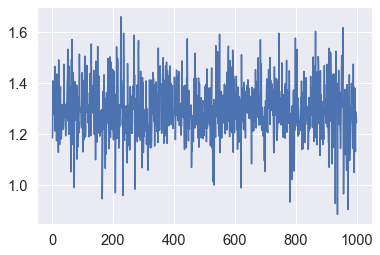

In [77]:
plt.plot(list_loss)

In [78]:
'''plot_train_history(single_step_history,
                   'Single Step Training and validation loss')'''

"plot_train_history(single_step_history,\n                   'Single Step Training and validation loss')"

In [79]:


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [80]:
for x, y in val_data_single.take(1):
    print(x.shape)

(16, 10, 7)


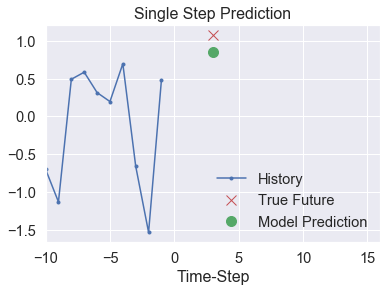

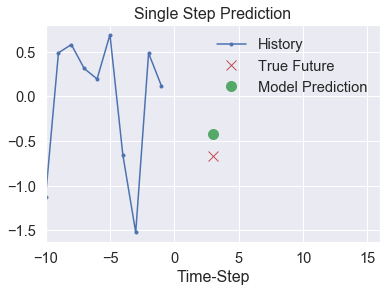

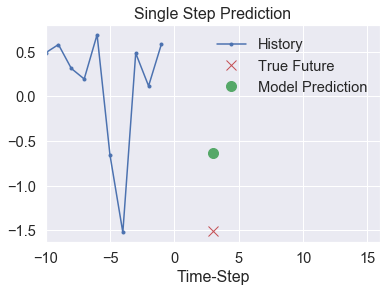

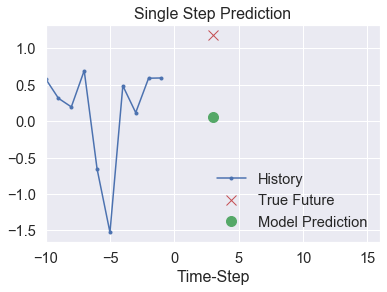

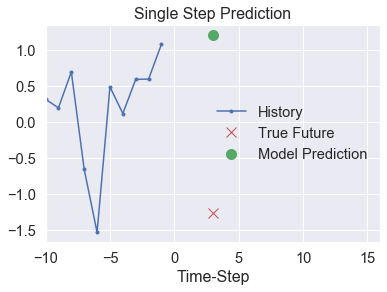

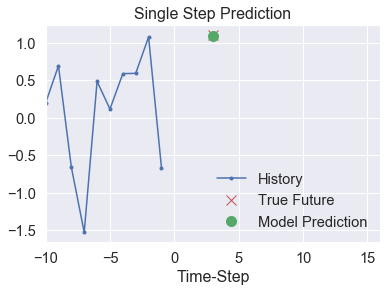

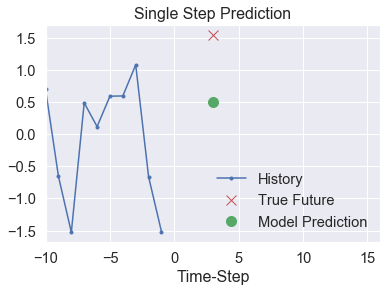

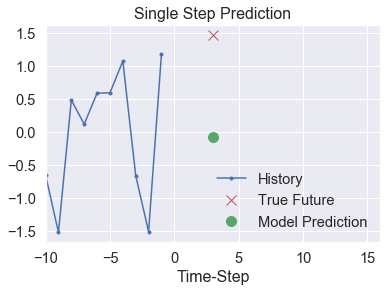

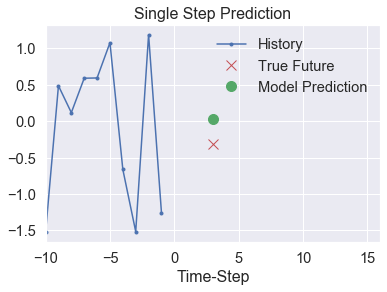

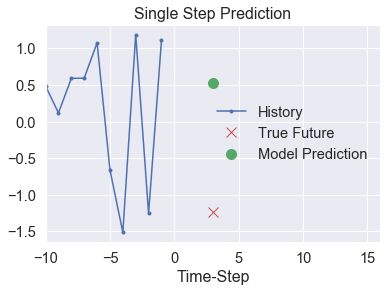

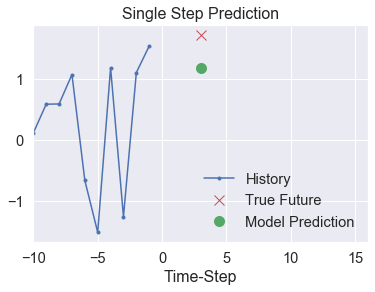

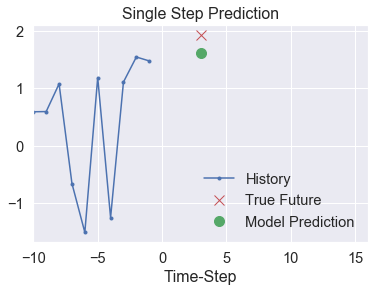

In [81]:
for x, y in val_data_single.take(1):
    for I in range(12):
        plot = show_plot([x[I][:, 4].numpy(), y[I].numpy(),
                        single_step_model.predict(x)[I]], 3,
                       'Single Step Prediction')
        plot.show()


## Multi-step model

### Helper functions

In [31]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 10D_to_3D

In [28]:
past_history = 10 # days used to predict next values in future
future_target = 3 # predict 3 days later
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=False)

In [29]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (10, 7)

 Target temperature to predict : (3,)


In [30]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

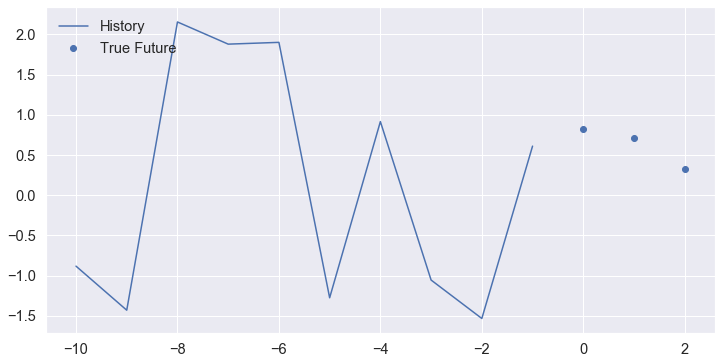

In [32]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [33]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 40
nb samples for validation : 12



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Run #0 : val_loss = 1.44020414352417


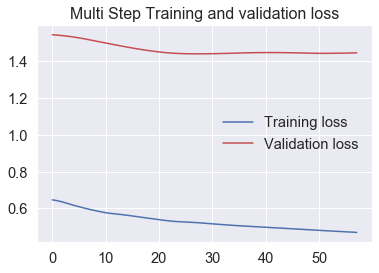

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #1 : val_loss = 1.380489468574524


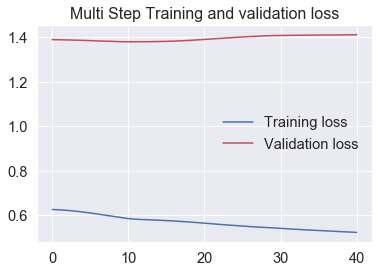

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
Run #2 : val_loss = 1.4505467414855957

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
Run #3 : val_loss = 1.4696327447891235

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00243: early stopping
Run #4 : val_loss = 1.2823010683059692


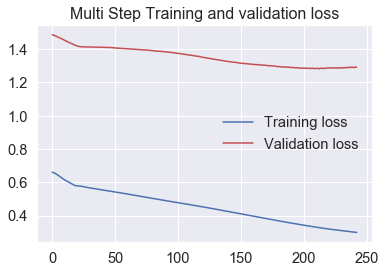

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
Run #5 : val_loss = 1.415507197380066

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
Run #6 : val_loss = 1.4288959503173828

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #7 : val_loss = 1.436025619506836

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
Run #8 : val_loss = 1.4264650344848633

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #9 : val_loss = 1.4336494207382202

 Run #10
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Run #10 : val_loss = 1.4785553216934204

 Run #11
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #11 : val_loss = 1.5398651361465454

 Run #1

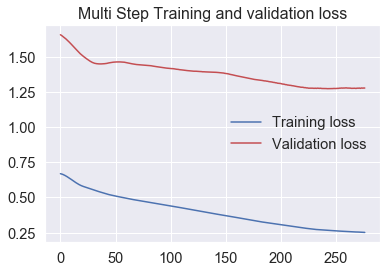

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #54
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
Run #54 : val_loss = 1.472550392150879

 Run #55
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #55 : val_loss = 1.4472540616989136

 Run #56
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Run #56 : val_loss = 1.4472907781600952

 Run #57
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Run #57 : val_loss = 1.4729598760604858

 Run #58
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
Run #58 : val_loss = 1.4383559226989746

 Run #59
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Run #59 : val_loss = 1.4479352235794067

 Run #60
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Run #60 : val_loss = 1.49716317653656

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Run #115 : val_loss = 1.6189459562301636

 Run #116
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #116 : val_loss = 1.4484915733337402

 Run #117
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #117 : val_loss = 1.442527174949646

 Run #118
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #118 : val_loss = 1.4614304304122925

 Run #119
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Run #119 : val_loss = 1.526093602180481

 Run #120
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Run #120 : val_loss = 1.5846151113510132

 Run #121
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
Run #121 : val_loss = 1.5853363275527954

 Run #122
Restoring model weights from the end of the best e

Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Run #176 : val_loss = 1.4707950353622437

 Run #177
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
Run #177 : val_loss = 1.4732685089111328

 Run #178
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #178 : val_loss = 1.47547447681427

 Run #179
Restoring model weights from the end of the best epoch.
Epoch 00147: early stopping
Run #179 : val_loss = 1.4244308471679688

 Run #180
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
Run #180 : val_loss = 1.5062618255615234

 Run #181
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
Run #181 : val_loss = 1.44288170337677

 Run #182
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
Run #182 : val_loss = 1.3920108079910278

 Run #183
Restoring model weights from the end of the best epo

Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #237 : val_loss = 1.423299789428711

 Run #238
Restoring model weights from the end of the best epoch.
Epoch 00180: early stopping
Run #238 : val_loss = 1.444314956665039

 Run #239
Restoring model weights from the end of the best epoch.
Epoch 00173: early stopping
Run #239 : val_loss = 1.359101414680481

 Run #240
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
Run #240 : val_loss = 1.4607867002487183

 Run #241
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
Run #241 : val_loss = 1.600408911705017

 Run #242
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Run #242 : val_loss = 1.4366741180419922

 Run #243
Restoring model weights from the end of the best epoch.
Epoch 00335: early stopping
Run #243 : val_loss = 1.3688807487487793

 Run #244
Restoring model weights from the end of the best epo

Restoring model weights from the end of the best epoch.
Epoch 00167: early stopping
Run #298 : val_loss = 1.3381637334823608

 Run #299
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Run #299 : val_loss = 1.4707962274551392

 Run #300
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #300 : val_loss = 1.412436604499817

 Run #301
Restoring model weights from the end of the best epoch.
Epoch 00150: early stopping
Run #301 : val_loss = 1.4442505836486816

 Run #302
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Run #302 : val_loss = 1.4638513326644897

 Run #303
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #303 : val_loss = 1.528779149055481

 Run #304
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Run #304 : val_loss = 1.4141660928726196

 Run #305
Restoring model weights from the end of the best e

Restoring model weights from the end of the best epoch.
Epoch 00200: early stopping
Run #359 : val_loss = 1.315537691116333

 Run #360
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Run #360 : val_loss = 1.398940086364746

 Run #361
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Run #361 : val_loss = 1.456515908241272

 Run #362
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Run #362 : val_loss = 1.5450350046157837

 Run #363
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #363 : val_loss = 1.4393582344055176

 Run #364
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Run #364 : val_loss = 1.4079642295837402

 Run #365
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #365 : val_loss = 1.4333189725875854

 Run #366
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Run #420 : val_loss = 1.5649439096450806

 Run #421
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
Run #421 : val_loss = 1.4442211389541626

 Run #422
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Run #422 : val_loss = 1.4674917459487915

 Run #423
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Run #423 : val_loss = 1.5245813131332397

 Run #424
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
Run #424 : val_loss = 1.4494050741195679

 Run #425
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Run #425 : val_loss = 1.4476302862167358

 Run #426
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
Run #426 : val_loss = 1.5598773956298828

 Run #427
Restoring model weights from the end of the best

Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
Run #481 : val_loss = 1.4018068313598633

 Run #482
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Run #482 : val_loss = 1.4153614044189453

 Run #483
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Run #483 : val_loss = 1.4616254568099976

 Run #484
Restoring model weights from the end of the best epoch.
Epoch 00139: early stopping
Run #484 : val_loss = 1.4301315546035767

 Run #485
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #485 : val_loss = 1.454136848449707

 Run #486
Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
Run #486 : val_loss = 1.4529228210449219

 Run #487
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
Run #487 : val_loss = 1.4502171277999878

 Run #488
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 00141: early stopping
Run #542 : val_loss = 1.4387813806533813

 Run #543
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Run #543 : val_loss = 1.4973243474960327

 Run #544
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #544 : val_loss = 1.4980368614196777

 Run #545
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run #545 : val_loss = 1.5703067779541016

 Run #546
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #546 : val_loss = 1.5282701253890991

 Run #547
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
Run #547 : val_loss = 1.412988305091858

 Run #548
Restoring model weights from the end of the best epoch.
Epoch 00222: early stopping
Run #548 : val_loss = 1.3080490827560425

 Run #549
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping
Run #603 : val_loss = 1.4916034936904907

 Run #604
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #604 : val_loss = 1.5140281915664673

 Run #605
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
Run #605 : val_loss = 1.3618589639663696

 Run #606
Restoring model weights from the end of the best epoch.
Epoch 00224: early stopping
Run #606 : val_loss = 1.3867839574813843

 Run #607
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #607 : val_loss = 1.4978398084640503

 Run #608
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Run #608 : val_loss = 1.4525829553604126

 Run #609
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
Run #609 : val_loss = 1.4685786962509155

 Run #610
Restoring model weights from the end of the best

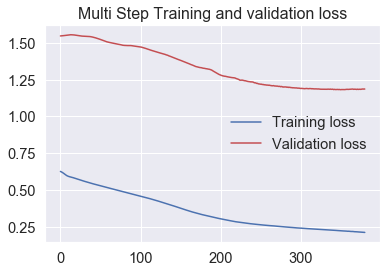

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #633
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Run #633 : val_loss = 1.4415861368179321

 Run #634
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
Run #634 : val_loss = 1.5323182344436646

 Run #635
Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping
Run #635 : val_loss = 1.416793704032898

 Run #636
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #636 : val_loss = 1.488663673400879

 Run #637
Restoring model weights from the end of the best epoch.
Epoch 00155: early stopping
Run #637 : val_loss = 1.46183443069458

 Run #638
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #638 : val_loss = 1.5721262693405151

 Run #639
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Run #639 : val_loss = 1.440

Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Run #693 : val_loss = 1.4381178617477417

 Run #694
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
Run #694 : val_loss = 1.3980928659439087

 Run #695
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
Run #695 : val_loss = 1.468317985534668

 Run #696
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Run #696 : val_loss = 1.4984911680221558

 Run #697
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Run #697 : val_loss = 1.4647201299667358

 Run #698
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Run #698 : val_loss = 1.509788155555725

 Run #699
Restoring model weights from the end of the best epoch.
Epoch 00174: early stopping
Run #699 : val_loss = 1.3974313735961914

 Run #700
Restoring model weights from the end of the best e

Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Run #754 : val_loss = 1.3922735452651978

 Run #755
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Run #755 : val_loss = 1.4710029363632202

 Run #756
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
Run #756 : val_loss = 1.484166145324707

 Run #757
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #757 : val_loss = 1.3392091989517212

 Run #758
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Run #758 : val_loss = 1.4000229835510254

 Run #759
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
Run #759 : val_loss = 1.4270076751708984

 Run #760
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Run #760 : val_loss = 1.5157079696655273

 Run #761
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Run #815 : val_loss = 1.3863054513931274

 Run #816
Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
Run #816 : val_loss = 1.3786550760269165

 Run #817
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #817 : val_loss = 1.4341155290603638

 Run #818
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Run #818 : val_loss = 1.4613434076309204

 Run #819
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Run #819 : val_loss = 1.4559763669967651

 Run #820
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Run #820 : val_loss = 1.4534717798233032

 Run #821
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Run #821 : val_loss = 1.3699254989624023

 Run #822
Restoring model weights from the end of the best

Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping
Run #876 : val_loss = 1.4523884057998657

 Run #877
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #877 : val_loss = 1.3064427375793457

 Run #878
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Run #878 : val_loss = 1.4519100189208984

 Run #879
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Run #879 : val_loss = 1.4660619497299194

 Run #880
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Run #880 : val_loss = 1.4793375730514526

 Run #881
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
Run #881 : val_loss = 1.5591812133789062

 Run #882
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Run #882 : val_loss = 1.4640058279037476

 Run #883
Restoring model weights from the end of the best

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Run #937 : val_loss = 1.450869083404541

 Run #938
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping
Run #938 : val_loss = 1.4561504125595093

 Run #939
Restoring model weights from the end of the best epoch.
Epoch 00188: early stopping
Run #939 : val_loss = 1.3738632202148438

 Run #940
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
Run #940 : val_loss = 1.4500840902328491

 Run #941
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Run #941 : val_loss = 1.4886493682861328

 Run #942
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
Run #942 : val_loss = 1.4692840576171875

 Run #943
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #943 : val_loss = 1.5737695693969727

 Run #944
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
Run #998 : val_loss = 1.4441324472427368

 Run #999
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Run #999 : val_loss = 1.4819631576538086
 
Final val_loss = 1.181632399559021
Mean asbolute Error in people : 321.40162855407556
 
Wall time: 47min 25s


In [71]:
%%time
'''
Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
'''
NB_TRY = 1000
EVALUATION_INTERVAL = 1
EPOCHS = 400

# Hyper-parameters
# lr=6e-2 : err=1.23 mais diverge
# lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
# lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
# lr=2e-2 : err=1.18 
lr = 2e-2
decay = 1e-6
momentum = 0.9
nesterov = True 


list_loss_multi = []


for I in range(NB_TRY):
    print("")
    print(f" Run #{I}")
    
    tf.keras.backend.clear_session()
    
    sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=30,
                                   restore_best_weights=True)
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(7, return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))    
    multi_step_model.add(tf.keras.layers.Dense(int(future_target/STEP)))
    
    multi_step_model.compile(optimizer=sgd_2, loss='mae')

    multi_step_history = multi_step_model.fit(train_data_multi, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=1,
                                            callbacks=[es],
                                            verbose=0)
    
    mae_curr = np.min(multi_step_history.history['val_loss'])
    
    ## re- eval best epoch model
    #y_val_multi_pred = multi_step_model.predict(x_val_multi)
    #mae_curr = mean_absolute_error(y_val_multi, y_val_multi_pred)
    if (I == 0):
        list_loss_multi.append(mae_curr)
        
    
    # find the best model
    print(f"Run #{I} : val_loss = {mae_curr}")
    if (mae_curr < np.min(list_loss_multi)) | (I == 0):
        # plot history
        plot_train_history(multi_step_history,
                   'Multi Step Training and validation loss')
        # save
        if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
            os.mkdir(PATH_MDL_MULTI_STEP)
        multi_step_model.save(PATH_MDL_MULTI_STEP)
        
    if (I != 0):   
        list_loss_multi.append(mae_curr)
    
print(" ")
print(f"Final val_loss = {np.min(list_loss_multi)}")
print("Mean asbolute Error in people :",
      data_std[4] * np.min(list_loss_multi))
print(" ")


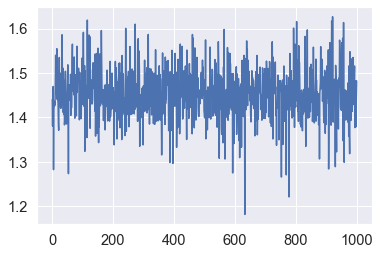

In [72]:
plt.plot(list_loss_multi)

### Eval

In [73]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

Wall time: 1.96 s


In [74]:
%%time
y_val_multi_pred = multi_step_model.predict(x_val_multi)
#mean_absolute_error(y_val_multi, y_val_multi_pred)

Wall time: 94 ms


In [75]:
multi_step_model.predict(x_val_multi)

array([[-1.1921599 , -0.9305426 ,  0.6248219 ],
       [ 0.22700435,  0.29514322,  0.71383834],
       [ 0.38074648,  0.4340515 ,  0.26013654],
       [ 1.1902369 ,  0.81542754,  0.4213034 ],
       [ 0.91310084,  0.41160053, -0.07058634],
       [ 0.45496854, -0.6250379 , -0.02669767],
       [-0.36744824, -1.4937167 ,  0.7704511 ],
       [-1.2303629 , -0.9302002 ,  0.8814761 ],
       [ 0.18001534,  0.34354347,  0.7803668 ],
       [ 0.4279813 ,  0.39203706,  0.4301942 ],
       [ 0.64726937,  0.34676796,  0.11869851],
       [ 0.62440795, -0.00167928, -0.041958  ]], dtype=float32)

In [76]:
y_val_multi_pred.shape

(12, 3)

In [77]:
val_data_multi

<RepeatDataset shapes: ((None, 10, 7), (None, 3)), types: (tf.float64, tf.float64)>

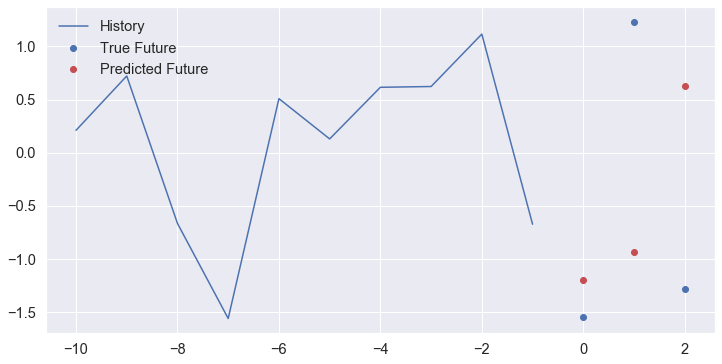

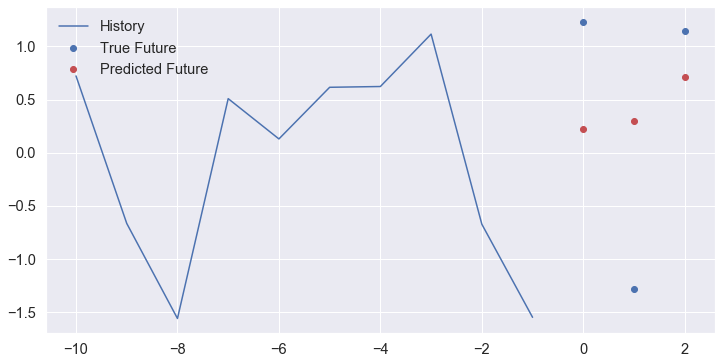

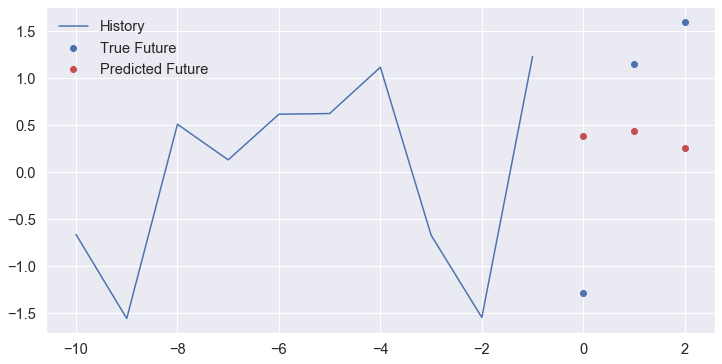

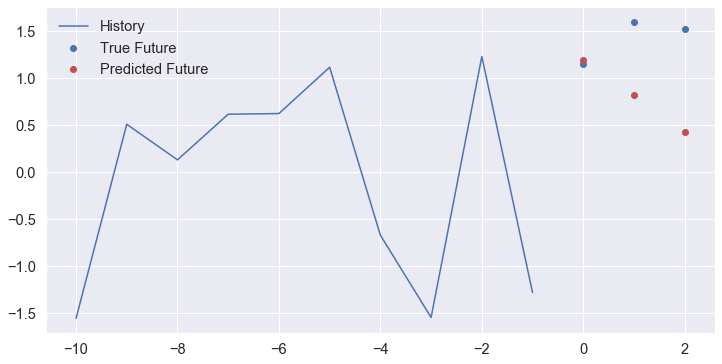

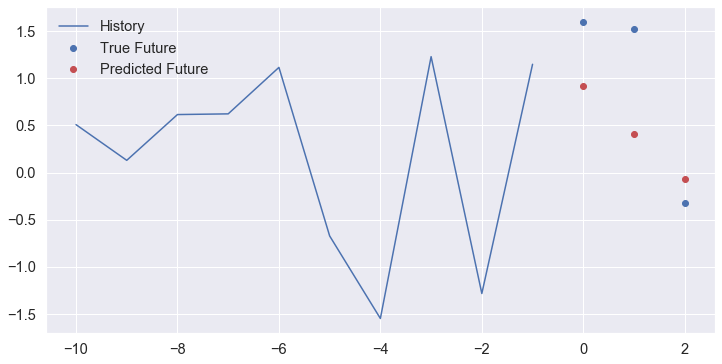

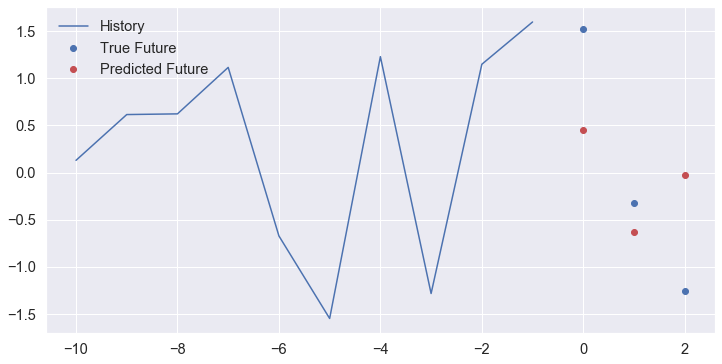

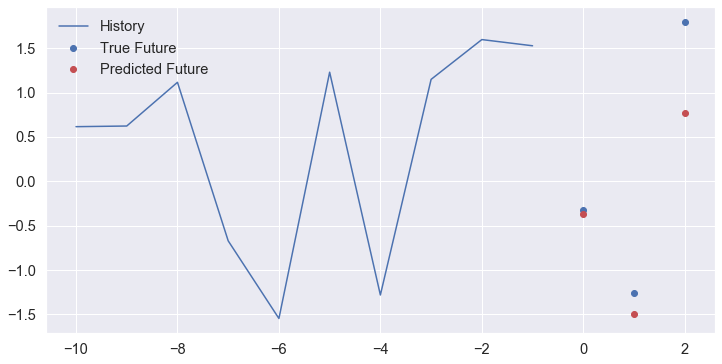

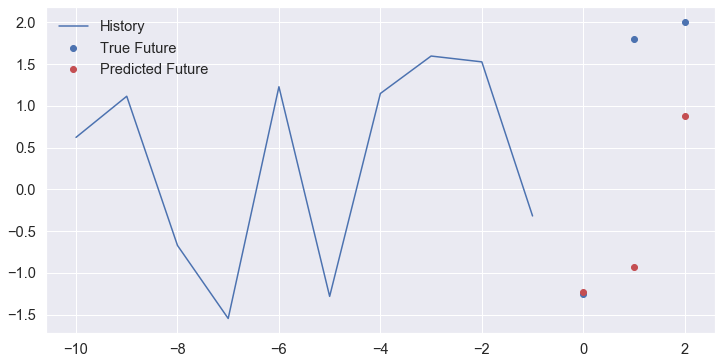

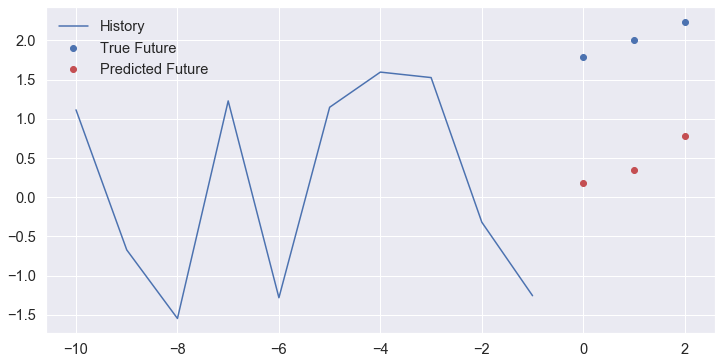

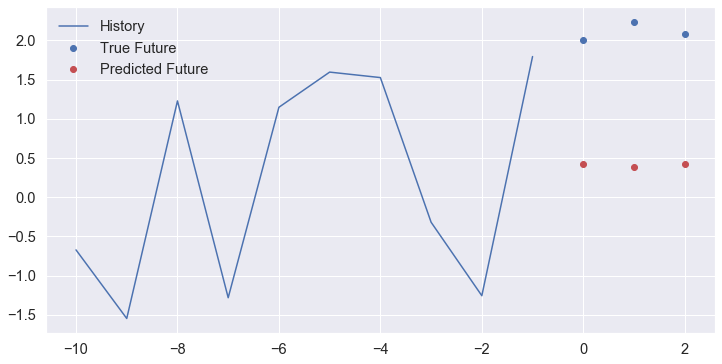

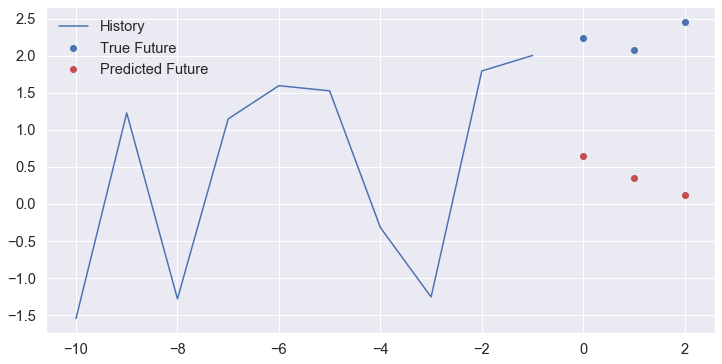

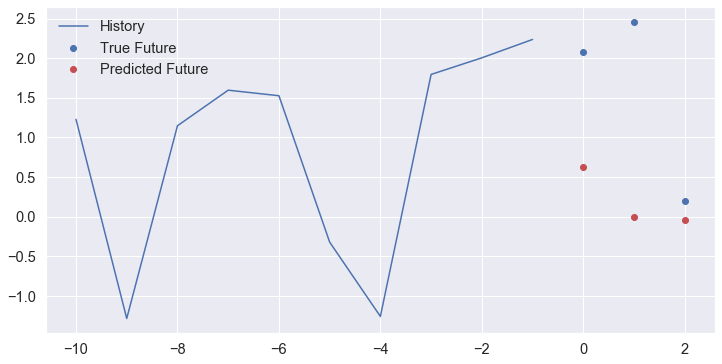

In [78]:
'''for x, y in val_data_single.take(1):
    for I in range(12):
        plot = show_plot([x[I][:, 4].numpy(), y[I].numpy(),
                        multi_step_model.predict(x)[I]], 3,
                       'Multi Step Prediction')
        plot.show()'''



for x, y in val_data_multi.take(1):
    for I in range(12):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Prediction

In [81]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a42fdd050> and <tensorflow.python.keras.layers.core.Dense object at 0x1a42fe6190>).


In [220]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num'])

In [221]:
# calculate mean & std 
train_split = 50
# prepare dataset
dataset = features.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [222]:
%%time
past_history = 10 # days used to predict next values in future
future_target = 3 # predict 3 days later
STEP = 1

# prepare data : very last days
x_multi = np.array([dataset[-past_history:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 48.7 ms, sys: 11.6 ms, total: 60.3 ms
Wall time: 71.7 ms


In [207]:
dataset[-past_history:,4] * data_std[4] + data_mean[4]

array([1256.,  612.,  258., 1389., 1319., 1420., 1496., 1539.,  736.,
        227.])

In [208]:
y_pos_pred

array([[452.73904, 596.1597 , 696.0136 ]], dtype=float32)

In [209]:
df_feat_fr.date.max()

'2020-08-02'

In [210]:
df_feat_fr.pos.std()

361.07085287370023

In [211]:
data_std[4]

272.32554048417865

In [212]:
df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,test,day_num,nb_cases
date,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,881,38923,3,141108
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,979,41695,4,142087
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,47156,5,143117
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,16186,6,143408
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,6278,0,143547
...,...,...,...,...,...,...,...,...,...
2020-07-29,2020-07-29,289.555085,299.031356,49.982759,85.379310,1420,95597,3,187263
2020-07-30,2020-07-30,290.362069,302.794828,44.333333,80.912281,1496,92410,4,188759
2020-07-31,2020-07-31,292.482203,303.165254,46.086207,78.103448,1539,95617,5,190298


In [213]:
'''###############
# FROM JHU CSSE
#
# confirmed cases
PATH_WORLD_CONF = 'https://raw.githubusercontent.com/CSSEGISandData/' + \
    'COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/' + \
    'time_series_covid19_confirmed_global.csv'
df_world = pd.read_csv(PATH_WORLD_CONF)

# fix problem no data at all for one date
df_world.dropna(axis='columns', how='all', inplace=True)

df_world_melt = df_world.melt(id_vars=["Province/State", "Country/Region", 
                                       "Lat", "Long"],
                            value_vars=df_world.columns[4:], 
                            var_name="date", value_name="nb_cases")

df_world_melt["Province/State"] = df_world_melt["Province/State"].fillna(" ")

df_world_melt["area"] = df_world_melt["Country/Region"] + " : " +\
    df_world_melt["Province/State"]  

df_world_melt["date"] = df_world_melt["date"].astype(np.datetime64)

df_world_melt.sort_values(by=['date'], inplace=True)

df_world_melt["nb_cases"] = df_world_melt["nb_cases"].fillna(0)
# path because sometimes, value are negative !
df_world_melt["nb_cases"] = df_world_melt["nb_cases"].apply(math.fabs)

# remove USA
df_world_melt = df_world_melt[df_world_melt["Country/Region"] != 'US']


df_cases_fr = extract_data_world(df_world_melt, None,
                                              "Country/Region", "France")'''

# last 60 days
NB_DAY_PLOT = 60
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

#nb_0 = df_cases_fr[df_cases_fr["date"] == str_date_0]['nb_cases'].values[0]
#arr_nb = df_feat_fr[df_feat_fr["date"] >= str_date_0]["pos"].cumsum().values
#df_plot["nb_cases"] = nb_0 + arr_nb

# pos pred next 3 days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, 3)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

,date,pos,nb_cases
2020-08-03,2020-08-03,452,191713
2020-08-04,2020-08-04,596,192309
2020-08-05,2020-08-05,696,193005


### Figure

In [214]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
fig.update_layout(title='COVID-19 Confirmed cases (France) 3 days prediction',
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))

fig.update_yaxes(range=[0, 5000], secondary_y=True)

fig.show()


### Predict all past

In [219]:
%%time
# prepare list of past histories
#past_history = 10 # days used to predict next values in future
#future_target = 3 # predict 3 days later
#STEP = 1
list_x = []
K_days = 0
# prepare data : very last days
nb_max = int((NB_DAY_PLOT)/future_target)
for I in range(nb_max, 0, -1):
    I_start = I * future_target - past_history
    if I_start < 0:
        break
    I_end = I * future_target
    print(f"[{I_start} - {I_end}]")
    list_x.append(np.array([dataset[I_start:I_end, :]]))
    K_days += future_target

print(len(list_x))

str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)


for I, x_multi in enumerate(list_x):
    if I:
       
        y_multi_pred = np.concatenate([y_multi_pred, 
                                       multi_step_model.predict(x_multi)],
                              axis=1)
    else:
        print("first...")
        y_multi_pred = multi_step_model.predict(x_multi)
    
# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4] 
y_pos_pred

[50 - 60]
[47 - 57]
[44 - 54]
[41 - 51]
[38 - 48]
[35 - 45]
[32 - 42]
[29 - 39]
[26 - 36]
[23 - 33]
[20 - 30]
[17 - 27]
[14 - 24]
[11 - 21]
[8 - 18]
[5 - 15]
[2 - 12]
17
51
2020-06-12
2020-08-02
first...
CPU times: user 823 ms, sys: 268 ms, total: 1.09 s
Wall time: 1.5 s


array([[202.63843 , 272.57574 , 697.09796 , 696.5969  , 456.0225  ,
        393.11487 , 693.88904 , 624.90137 , 657.848   , 673.29065 ,
        251.06454 , 490.30536 , 680.6093  , 677.96924 , 604.1233  ,
        337.37805 , 216.20798 , 556.9435  , 661.86694 , 634.08093 ,
        513.5844  , 113.54895 , 470.9671  , 651.8176  , 602.18536 ,
        423.88373 , 381.14105 , 488.74118 , 571.12726 , 571.142   ,
        440.54395 , 270.1895  , 363.92065 , 546.2462  , 587.4452  ,
        507.10458 , 265.43716 ,  89.238556, 484.49228 , 635.9889  ,
        640.6688  , 502.51608 , 164.71631 , 277.907   , 605.14154 ,
        621.07007 , 524.92944 , 336.08228 , 637.3639  , 708.0774  ,
        721.71204 ]], dtype=float32)

In [216]:
# figure 
df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred_all["pos"].cumsum().values
df_plot_pred_all["nb_cases"] = df_feat_fr[df_feat_fr["date"] == \
    df_plot_pred_all["date"].min()]["nb_cases"][0] + arr_nb_pred


df_plot_pred_all

,date,pos,nb_cases
2020-06-13,2020-06-13,202,157958
2020-06-14,2020-06-14,272,158230
2020-06-15,2020-06-15,697,158927
2020-06-16,2020-06-16,696,159623
2020-06-17,2020-06-17,456,160079
2020-06-18,2020-06-18,393,160472
2020-06-19,2020-06-19,693,161165
2020-06-20,2020-06-20,624,161789
2020-06-21,2020-06-21,657,162446
2020-06-22,2020-06-22,673,163119


In [223]:
df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,test,day_num,nb_cases
date,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,881,38923,3,141108
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,979,41695,4,142087
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,47156,5,143117
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,16186,6,143408
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,6278,0,143547
...,...,...,...,...,...,...,...,...,...
2020-07-29,2020-07-29,289.555085,299.031356,49.982759,85.379310,1420,95597,3,187263
2020-07-30,2020-07-30,290.362069,302.794828,44.333333,80.912281,1496,92410,4,188759
2020-07-31,2020-07-31,292.482203,303.165254,46.086207,78.103448,1539,95617,5,190298


### Figure all past 

In [218]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Future pred."),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily pred."), 
            secondary_y=True)

fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines',
                    line_shape='linear',
                    connectgaps=True, name="Past pred."),
             secondary_y=False)
# Edit the layout
fig.update_layout(title='COVID-19 Confirmed cases (France) all past prediction',
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))

fig.update_yaxes(range=[0, 5000], secondary_y=True)

fig.show()


In [182]:
df_plot_pred_all["date"].min()

'2020-05-22'

In [183]:
df_plot["date"]

date
2020-06-02    2020-06-02
2020-06-03    2020-06-03
2020-06-04    2020-06-04
2020-06-05    2020-06-05
2020-06-06    2020-06-06
                 ...    
2020-07-28    2020-07-28
2020-07-29    2020-07-29
2020-07-30    2020-07-30
2020-07-31    2020-07-31
2020-08-01    2020-08-01
Name: date, Length: 61, dtype: object

In [187]:
df_feat_fr[df_feat_fr["date"] == \
    df_plot_pred_all["date"].min()]["nb_cases"][0]

147692

In [160]:
df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,test,day_num,nb_cases
date,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,881,38922,3,141108
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,979,41695,4,142087
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,47156,5,143117
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,287,16181,6,143404
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,138,6276,0,143542
...,...,...,...,...,...,...,...,...,...
2020-07-28,2020-07-28,291.130000,298.003333,55.711864,85.576271,1318,92804,2,185826
2020-07-29,2020-07-29,289.555085,299.031356,49.982759,85.379310,1411,95206,3,187237
2020-07-30,2020-07-30,290.362069,302.794828,44.333333,80.912281,1482,91778,4,188719


In [154]:
(81-10)/3

23.666666666666668

In [153]:
dataset[0:, 0].shape

(81,)

In [137]:
I_end

85

In [138]:
dataset.shape

(81, 7)

In [139]:
list_x

[array([[[-1.6124911 , -2.05376005,  1.68428125,  0.72301023,
           1.30139085,  0.32108372,  0.        ],
         [-1.5358529 , -1.86126426,  0.79496158, -0.24603766,
           1.66158149,  0.49576171,  0.50507627],
         [-1.37532694, -1.45947306,  0.4507088 , -0.80049291,
           1.84902764,  0.83976334,  1.01015254],
         [-1.59384938, -0.79588759, -0.16395057,  0.25114626,
          -0.8818055 , -1.11142698,  1.51522882],
         [-1.19512361, -0.3982963 , -0.81763515, -0.05372661,
          -1.4294423 , -1.73536693, -1.51522882],
         [-1.26307287,  0.04872103, -0.89350926, -0.06897026,
           2.15408707,  1.03189023, -1.01015254],
         [-0.90393004,  0.33061316, -1.2670433 , -0.90228944,
           1.87843096,  1.14137106, -0.50507627],
         [-0.30781614,  0.94636239, -0.82055339, -1.05980709,
           1.89680804,  1.11535519,  0.        ],
         [ 0.49947456,  1.29854023, -1.25662104, -0.59578332,
          -1.27507488, -1.56654724,  0.505

In [124]:
int((dataset.shape[0]-past_history-future_target)/future_target)

22

In [126]:
22*3+10+3

79

In [128]:
dataset.shape

(81, 7)

In [62]:
days_between(df_feat_fr["date"].max(), 
    datetime.datetime.now().strftime(date_format)).days

4

In [64]:
dt_file = datetime.datetime.utcfromtimestamp(os.path.getmtime( \
        PATH_DF_FEAT_FR)).strftime(date_format)
dt_file

'2020-07-31'

In [73]:
dt = (datetime.datetime.now() - datetime.datetime.utcfromtimestamp(os.path.getmtime( \
        PATH_DF_FEAT_FR)))

In [78]:
dt.days

0

In [77]:
9189/3600

2.5525

In [96]:
df_plot_pred.to_json(date_format='iso', orient='split')

'{"columns":["date","pos","nb_cases"],"index":["2020-08-02","2020-08-03","2020-08-04"],"data":[["2020-08-02",72,227534.0],["2020-08-03",66,227600.0],["2020-08-04",775,228375.0]]}'

In [97]:
df_plot_pred.to_json(date_format='iso')

'{"date":{"2020-08-02":"2020-08-02","2020-08-03":"2020-08-03","2020-08-04":"2020-08-04"},"pos":{"2020-08-02":72,"2020-08-03":66,"2020-08-04":775},"nb_cases":{"2020-08-02":227534.0,"2020-08-03":227600.0,"2020-08-04":228375.0}}'

In [98]:
datetime.datetime.now()

datetime.datetime(2020, 8, 6, 8, 40, 28, 808640)

In [99]:
pd.read_json(df_plot_pred.to_json(date_format='iso', orient='split'), orient='split')

,date,pos,nb_cases
2020-08-02,2020-08-02,72,227534
2020-08-03,2020-08-03,66,227600
2020-08-04,2020-08-04,775,228375


In [100]:
df_plot_pred

,date,pos,nb_cases
2020-08-02,2020-08-02,72,227534.0
2020-08-03,2020-08-03,66,227600.0
2020-08-04,2020-08-04,775,228375.0
